# 7.2 Easy Genre, Difficult Genre: Why is there Variance in the Results of the Classification?

In [1]:
import sys
import os
import shutil
import datetime
import re
import pandas as pd
from collections import Counter
sys.path.append(os.path.abspath("/home/jose/Dropbox/Doktorarbeit/"))
from reading_robot import load_data, tei2text, text2features, classify, process_labels, describe_data,feature_analysis, cull_data, st_tests, metadata2numbers, cluster, call_stylo, prepare_subcorpus
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline
from shutil import copyfile
import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
ne_dir = "/home/jose/Dropbox/Doktorarbeit/novelasespanolas/"

In [3]:
wdir = "/home/jose/Dropbox/Doktorarbeit/ne_data/chap7_2/"

# 7.2.0. Getting Data

## Getting Files 

In [4]:
copyfile(ne_dir + "exported/tags_ling_pos_diff_mw_ord_ent_70000_T.parquet", wdir +"tags_ling_pos_diff_mw_ord_ent_70000_T.parquet")
copyfile(ne_dir+"metadata_beta-opt-obl-structure.csv", wdir + "metadata_beta-opt-obl-structure.csv")
copyfile(ne_dir+"metadata_recategorized.csv", wdir + "metadata_recategorized.csv")
copyfile(ne_dir+"exported/chapters_txt_freq_table_raw_10000_T.parquet", wdir + "chapters_txt_freq_table_raw_10000_T.parquet")
copyfile(ne_dir+"basic_metadata_chapters.csv", wdir + "basic_metadata_chapters.csv")
copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap5_1/labels_agreement.csv", wdir + "labels_agreement.csv")
copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap7_1/classification_results_linguistic_features.csv", wdir + "classification_results_linguistic_features.csv")
copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap7_1/classification_results_metadata.csv", wdir + "classification_results_metadata.csv")
copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap7_1/combined_results_metadata.csv", wdir + "combined_results_metadata.csv")


'/home/jose/Dropbox/Doktorarbeit/ne_data/chap7_2/combined_results_metadata.csv'

## Getting Data from Previous Chapter


In [5]:

classification_results_linguistic_features_df = pd.read_csv(wdir+"classification_results_linguistic_features.csv", sep="\t", index_col=0)
classification_results_metadata_df = pd.read_csv(wdir+"classification_results_metadata.csv",sep="\t",index_col=0)
combined_results_metadata_df = pd.read_csv(wdir+"combined_results_metadata.csv", sep="\t", index_col=0)


## Getting Metadata

In [6]:
metadata_df = pd.read_csv(wdir+"metadata_beta-opt-obl-structure.csv",index_col=0,sep=",").fillna(0)
metadata_df.shape

(358, 177)

In [7]:
independent_sources_genre = ['subgenre.cligs', 'subgenre.lithist.MdLE', 'subgenre.lithist.HdLE', 'subgenre.edit.epublibre', 'subgenre.edit.amazon','subgenre.subtitle.bne','subgenre.cluster']

Calculate number of sources that labels each text:

In [8]:
metadata_df["number.sources"] = 0
for index, row in metadata_df.iterrows():
    i = 0
    for independent_source_genre in independent_sources_genre:

        if row[independent_source_genre] != 0:
            i += 1
    metadata_df.loc[index,"number.sources"] = i
    

In [9]:
metadata_df[independent_sources_genre+["number.sources"]]

,subgenre.cligs,subgenre.lithist.MdLE,subgenre.lithist.HdLE,subgenre.edit.epublibre,subgenre.edit.amazon,subgenre.subtitle.bne,subgenre.cluster,number.sources
ne0001,"naturalist,sentimental,social,realist",0,0,"Aventuras, Drama",Ficción contemporánea; Ficción clásica; Litera...,0,0,3
ne0002,"naturalist,social,realist",novela de tesis,0,Realista,"Ficción clásica, Bibliotecas, Libros escolares...",0,0,4
ne0003,"naturalist,social,spiritual,realist",novela espiritualista,0,Drama,"Ficción, Europea, Antologías; Ficción clásica;...",0,0,4
ne0004,"sentimental,social,spiritual,realist",novela espiritual,0,"Drama, Realista","Siglo XIX, Antigua y clásica; Ficción clásica;...",0,0,4
ne0005,"naturalist,realist,sentimental,social,spiritua...",novela espiritual,0,Realista,"Ficción clásica, Ficción contemporánea; Ficció...",0,0,4
ne0006,"naturalist,realist,sentimental,social,spiritua...",novela espiritual,0,Realista,"Ficción clásica; Europea, Antologías",0,0,4
ne0007,"naturalist,realist,social,erotic",novela naturalista,novela naturalista,Drama,"Ficción clásica ; Europea, Teatro ; Romántica,...",0,0,5
ne0008,"realist,social,erotic",novela erótica,0,0,Ficción clásica;,"novela, novela original",0,4
ne0009,"naturalist,realist,sentimental,social,bildungs...",novela naturalista,novela realista,Drama,"Ficción clásica; Ficción clásica, Ficción hist...",0,0,5
ne0010,"social,philosophical",0,0,0,Historia;,novela,0,3


The references are loaded:

In [10]:
reference_labels_df = pd.read_csv("/home/jose/Dropbox/Doktorarbeit/reading_robot/data/tokens-labels_semantic-labels.csv", sep="\t",index_col=False)
reference_labels_df.shape

(276, 4)

In [11]:
independent_sources_genre

['subgenre.cligs',
 'subgenre.lithist.MdLE',
 'subgenre.lithist.HdLE',
 'subgenre.edit.epublibre',
 'subgenre.edit.amazon',
 'subgenre.subtitle.bne',
 'subgenre.cluster']

The semantic labels are obtained:

In [12]:
semantic_labels_df = process_labels.modelize_metadata_labels(metadata_df[independent_sources_genre], wdir, reference_labels_df, reference_column = "semantic_label_reference").fillna("")

In [13]:
semantic_labels_df.head()

,subgenre.cligs,subgenre.lithist.MdLE,subgenre.lithist.HdLE,subgenre.edit.epublibre,subgenre.edit.amazon,subgenre.subtitle.bne,subgenre.cluster
ne0001,"naturalista,sentimental,social,realista",,,"aventura,drama",ficción-literaria;ficción-literaria;ficción-li...,,
ne0002,"naturalista,social,realista",de tesis,,realista,"ficción-literaria,biblioteca,juvenil-infantil;...",,
ne0003,"naturalista,social,espiritual,realista",espiritual,,drama,"ficción,europea,antología;ficción-literaria;fi...",,
ne0004,"sentimental,social,espiritual,realista",espiritual,,"drama,realista","siglo-xix,clásico;ficción-literaria;antología;",,
ne0005,"naturalista,realista,sentimental,social,espiri...",espiritual,,realista,"ficción-literaria,ficción-literaria;ficción-li...",,


In [14]:
semantic_subgenres_lt = ["autobiografía","aventura","biografía","costumbrista","diálogo","educación","episodio nacional","erótica","espiritual","fantástico","filosófica","greguería","guerra","histórica","humor","memorias","modernista","naturalista","nivola","poética","psicológica","realista","social","bucólica","mono-diálogo","ficción-literaria"]

Quantification of each label in each text:

In [15]:
quantified_subgenre_df =  process_labels.count_labels_from_sources(semantic_subgenres_lt, semantic_labels_df, independent_sources_genre, wdir) 


subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenr

subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subge

subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
s

subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía
subgenre.edit.epublibre autobiografía
subgenre.edit.amazon autobiografía
subgenre.subtitle.bne autobiografía
subgenre.cluster autobiografía
subgenre.cligs autobiografía
subgenre.lithist.MdLE autobiografía
subgenre.lithist.HdLE autobiografía


subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne avent

subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura


subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura
subgenre.edit.amazon aventura
subgenre.subtitle.bne aventura
subgenre.cluster aventura
subgenre.cligs aventura
subgenre.lithist.MdLE aventura
subgenre.lithist.HdLE aventura
subgenre.edit.epublibre aventura


subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biog

subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografía
subgenre.edit.amazon biografía
subgenre.subtitle.bne biografía
subgenre.cluster biografía
subgenre.cligs biografía
subgenre.lithist.MdLE biografía
subgenre.lithist.HdLE biografía
subgenre.edit.epublibre biografí

subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgen

subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista

subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costumbrista
subgenre.subtitle.bne costumbrista
subgenre.cluster costumbrista
subgenre.cligs costumbrista
subgenre.lithist.MdLE costumbrista
subgenre.lithist.HdLE costumbrista
subgenre.edit.epublibre costumbrista
subgenre.edit.amazon costum

subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subge

subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subgenre.cligs diálogo
subgenre.lithist.MdLE diálogo
subgenre.lithist.HdLE diálogo
subgenre.edit.epublibre diálogo
subgenre.edit.amazon diálogo
subgenre.subtitle.bne diálogo
subgenre.cluster diálogo
subge

subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación

subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación


subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
subgenre.lithist.HdLE educación
subgenre.edit.epublibre educación
subgenre.edit.amazon educación
subgenre.subtitle.bne educación
subgenre.cluster educación
subgenre.cligs educación
subgenre.lithist.MdLE educación
s

subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
sub

subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional

subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subgenre.edit.epublibre episodio nacional
subgenre.edit.amazon episodio nacional
subgenre.subtitle.bne episodio nacional
subgenre.cluster episodio nacional
subgenre.cligs episodio nacional
subgenre.lithist.MdLE episodio nacional
subgenre.lithist.HdLE episodio nacional
subge

subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subge

subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subgenre.cligs erótica
subgenre.lithist.MdLE erótica
subgenre.lithist.HdLE erótica
subgenre.edit.epublibre erótica
subgenre.edit.amazon erótica
subgenre.subtitle.bne erótica
subgenre.cluster erótica
subge

subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual


subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual


subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual
subgenre.lithist.HdLE espiritual
subgenre.edit.epublibre espiritual
subgenre.edit.amazon espiritual
subgenre.subtitle.bne espiritual
subgenre.cluster espiritual
subgenre.cligs espiritual
subgenre.lithist.MdLE espiritual


subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fant

subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
s

subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fantástico
subgenre.cligs fantástico
subgenre.lithist.MdLE fantástico
subgenre.lithist.HdLE fantástico
subgenre.edit.epublibre fantástico
subgenre.edit.amazon fantástico
subgenre.subtitle.bne fantástico
subgenre.cluster fan

subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filo

subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filosófica
subgenre.edit.amazon filosófica
subgenre.subtitle.bne filosófica
subgenre.cluster filosófica
subgenre.cligs filosófica
subgenre.lithist.MdLE filosófica
subgenre.lithist.HdLE filosófica
subgenre.edit.epublibre filo

subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería


subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería

subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
subgenre.lithist.HdLE greguería
subgenre.edit.epublibre greguería
subgenre.edit.amazon greguería
subgenre.subtitle.bne greguería
subgenre.cluster greguería
subgenre.cligs greguería
subgenre.lithist.MdLE greguería
s

subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cl

subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.M

subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.edit.epublibre guerra
subgenre.edit.amazon guerra
subgenre.subtitle.bne guerra
subgenre.cluster guerra
subgenre.cligs guerra
subgenre.lithist.MdLE guerra
subgenre.lithist.HdLE guerra
subgenre.ed

subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica


subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
s

subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon histórica
subgenre.subtitle.bne histórica
subgenre.cluster histórica
subgenre.cligs histórica
subgenre.lithist.MdLE histórica
subgenre.lithist.HdLE histórica
subgenre.edit.epublibre histórica
subgenre.edit.amazon hist

subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humo

subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.amazon humor
subgenre.subtitle.bne humor
subgenre.cluster humor
subgenre.cligs humor
subgenre.lithist.MdLE humor
subgenre.lithist.HdLE humor
subgenre.edit.epublibre humor
subgenre.edit.ama

subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias


subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias


subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster memorias
subgenre.cligs memorias
subgenre.lithist.MdLE memorias
subgenre.lithist.HdLE memorias
subgenre.edit.epublibre memorias
subgenre.edit.amazon memorias
subgenre.subtitle.bne memorias
subgenre.cluster mem

subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre mode

subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista


subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre modernista
subgenre.edit.amazon modernista
subgenre.subtitle.bne modernista
subgenre.cluster modernista
subgenre.cligs modernista
subgenre.lithist.MdLE modernista
subgenre.lithist.HdLE modernista
subgenre.edit.epublibre mode

subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
su

subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre 

subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre naturalista
subgenre.edit.amazon naturalista
subgenre.subtitle.bne naturalista
subgenre.cluster naturalista
subgenre.cligs naturalista
subgenre.lithist.MdLE naturalista
subgenre.lithist.HdLE naturalista
subgenre.edit.epublibre 

subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cl

subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cluster nivola
subgenre.cligs nivola
subgenre.lithist.MdLE nivola
subgenre.lithist.HdLE nivola
subgenre.edit.epublibre nivola
subgenre.edit.amazon nivola
subgenre.subtitle.bne nivola
subgenre.cl

subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subge

subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subge

subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subgenre.subtitle.bne poética
subgenre.cluster poética
subgenre.cligs poética
subgenre.lithist.MdLE poética
subgenre.lithist.HdLE poética
subgenre.edit.epublibre poética
subgenre.edit.amazon poética
subge

subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon p

subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon p

subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon psicológica
subgenre.subtitle.bne psicológica
subgenre.cluster psicológica
subgenre.cligs psicológica
subgenre.lithist.MdLE psicológica
subgenre.lithist.HdLE psicológica
subgenre.edit.epublibre psicológica
subgenre.edit.amazon p

subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
s

subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
subgenre.subtitle.bne realista
subgenre.cluster realista
subgenre.cligs realista
subgenre.lithist.MdLE realista
subgenre.lithist.HdLE realista
subgenre.edit.epublibre realista
subgenre.edit.amazon realista
s

subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.ed

subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.M

subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs social
subgenre.lithist.MdLE social
subgenre.lithist.HdLE social
subgenre.edit.epublibre social
subgenre.edit.amazon social
subgenre.subtitle.bne social
subgenre.cluster social
subgenre.cligs s

subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
sub

subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucól

subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
subgenre.lithist.HdLE bucólica
subgenre.edit.epublibre bucólica
subgenre.edit.amazon bucólica
subgenre.subtitle.bne bucólica
subgenre.cluster bucólica
subgenre.cligs bucólica
subgenre.lithist.MdLE bucólica
s

subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
s

subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
s

subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-diálogo
subgenre.edit.epublibre mono-diálogo
subgenre.edit.amazon mono-diálogo
subgenre.subtitle.bne mono-diálogo
subgenre.cluster mono-diálogo
subgenre.cligs mono-diálogo
subgenre.lithist.MdLE mono-diálogo
subgenre.lithist.HdLE mono-di

subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgen

subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
sub

subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria
subgenre.subtitle.bne ficción-literaria
subgenre.cluster ficción-literaria
subgenre.cligs ficción-literaria
subgenre.lithist.MdLE ficción-literaria
subgenre.lithist.HdLE ficción-literaria
subgenre.edit.epublibre ficción-literaria
subgenre.edit.amazon ficción-literaria

In [16]:
quantified_subgenre_df.head()

,autobiografía,aventura,biografía,costumbrista,diálogo,educación,episodio nacional,erótica,espiritual,fantástico,...,modernista,naturalista,nivola,poética,psicológica,realista,social,bucólica,mono-diálogo,ficción-literaria
ne0001,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
ne0002,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,2,1,0,0,1
ne0003,0,0,0,0,0,0,0,0,2,0,...,0,1,0,0,0,1,1,0,0,1
ne0004,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,2,1,0,0,1
ne0005,0,0,0,0,0,1,0,0,2,0,...,0,1,0,0,0,2,1,0,0,1


In [17]:
bool_quantified_subgenre_df = (quantified_subgenre_df > 0).astype(int)
bool_quantified_subgenre_df.head(15)

,autobiografía,aventura,biografía,costumbrista,diálogo,educación,episodio nacional,erótica,espiritual,fantástico,...,modernista,naturalista,nivola,poética,psicológica,realista,social,bucólica,mono-diálogo,ficción-literaria
ne0001,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
ne0002,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,1
ne0003,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,1,0,0,1
ne0004,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1
ne0005,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,1
ne0006,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,1
ne0007,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,1
ne0008,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
ne0009,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
ne0010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
rel_quantified_subgenre_df = quantified_subgenre_df.divide(metadata_df["number.sources"],axis=0)
rel_quantified_subgenre_df.head(5)

,autobiografía,aventura,biografía,costumbrista,diálogo,educación,episodio nacional,erótica,espiritual,fantástico,...,modernista,naturalista,nivola,poética,psicológica,realista,social,bucólica,mono-diálogo,ficción-literaria
ne0001,0,0.333333,0,0,0,0,0,0,0,0,...,0,0.333333,0,0,0,0.333333,0.333333,0,0,0.333333
ne0002,0,0,0,0,0,0,0,0,0,0.25,...,0,0.25,0,0,0,0.5,0.25,0,0,0.25
ne0003,0,0,0,0,0,0,0,0,0.5,0,...,0,0.25,0,0,0,0.25,0.25,0,0,0.25
ne0004,0,0,0,0,0,0,0,0,0.5,0,...,0,0,0,0,0,0.5,0.25,0,0,0.25
ne0005,0,0,0,0,0,0.25,0,0,0.5,0,...,0,0.25,0,0,0,0.5,0.25,0,0,0.25


In [19]:
rel_quantified_subgenre_df.to_csv(ne_dir+"rel_quantified_labels.csv",sep="\t")

In [20]:
rel_quantified_subgenre_df.mean(axis=1)

ne0001    0.064103
ne0002    0.067308
ne0003    0.057692
ne0004    0.057692
ne0005    0.076923
ne0006    0.076923
ne0007    0.053846
ne0008    0.048077
ne0009    0.061538
ne0010    0.025641
ne0011    0.069231
ne0013    0.053846
ne0014    0.061538
ne0015    0.061538
ne0016    0.069231
ne0017    0.053846
ne0018    0.028846
ne0019    0.044872
ne0020    0.086538
ne0021    0.076923
ne0022    0.096154
ne0023    0.076923
ne0024    0.089744
ne0025    0.048077
ne0026    0.048077
ne0027    0.057692
ne0028    0.067308
ne0029    0.067308
ne0030    0.053846
ne0031    0.067308
            ...   
ne0360    0.019231
ne0361    0.076923
ne0362    0.038462
ne0363    0.038462
ne0364    0.038462
ne0365    0.038462
ne0370    0.051282
ne0373    0.030769
ne0378    0.048077
ne0379    0.067308
ne0380    0.028846
ne0381    0.038462
ne0382    0.057692
ne0384    0.096154
ne0385    0.038462
ne0387    0.053846
ne0388    0.051282
ne0390    0.076923
ne0391    0.025641
ne0392    0.025641
ne0393    0.076923
ne0394    0.

In [21]:
new_metadata_df = pd.concat([metadata_df, bool_quantified_subgenre_df], axis=1)
new_metadata_df = new_metadata_df.loc[(new_metadata_df["genre.analyzed"]=="novela")]
new_metadata_df.shape

(352, 204)

In [22]:
new_metadata_df["mean.prop.subgenres"] = rel_quantified_subgenre_df.mean(axis=1)

In [23]:
new_metadata_df.head()

,idno,author.name,title,year,supergenre,genre,subgenre.cligs.important,author.country,author.viaf,author.bne,...,naturalista,nivola,poética,psicológica,realista,social,bucólica,mono-diálogo,ficción-literaria,mean.prop.subgenres
ne0001,ne0001,Baroja,Mayorazgo,1903,narrative,novela,realist,Spain,36912891.0,XX842743,...,1,0,0,0,1,1,0,0,1,0.064103
ne0002,ne0002,Galdos,Misericordia,1889,narrative,novela,realist,Spain,71395987.0,XX1014802,...,1,0,0,0,1,1,0,0,1,0.067308
ne0003,ne0003,Galdos,Nazarin,1895,narrative,novela,realist,Spain,71395987.0,XX1014802,...,1,0,0,0,1,1,0,0,1,0.057692
ne0004,ne0004,Galdos,Halma,1895,narrative,novela,realist,Spain,71395987.0,XX1014802,...,0,0,0,0,1,1,0,0,1,0.057692
ne0005,ne0005,Galdos,Tristana,1892,narrative,novela,bildungsroman,Spain,71395987.0,XX1014802,...,1,0,0,0,1,1,0,0,1,0.076923


In [24]:
metadata_recategorized_df = pd.read_csv(wdir+"metadata_recategorized.csv",sep="\t", index_col=0)
metadata_recategorized_df.head()

,idno,author.name,title,year,supergenre,genre,subgenre.cligs.important,author.country,author.viaf,author.bne,...,author.movement_ordinal,author.submovement_ordinal,authorText.relation_ordinal,litHist.brow_ordinal,setting.type_ordinal,time.period_ordinal,protagonist.age_ordinal,protagonist.socLevel_ordinal,end_ordinal,representation_ordinal
ne0001,ne0001,Baroja,Mayorazgo,1903,narrative,novela,realist,Spain,36912891.0,XX842743,...,1,4,0,NaN,1,3,3,2,4,2
ne0002,ne0002,Galdos,Misericordia,1889,narrative,novela,realist,Spain,71395987.0,XX1014802,...,0,0,0,NaN,3,3,2,0,0,2
ne0003,ne0003,Galdos,Nazarin,1895,narrative,novela,realist,Spain,71395987.0,XX1014802,...,0,0,0,0.0,-,3,2,0,4,2
ne0004,ne0004,Galdos,Halma,1895,narrative,novela,realist,Spain,71395987.0,XX1014802,...,0,0,0,NaN,3,3,2,2,4,2
ne0005,ne0005,Galdos,Tristana,1892,narrative,novela,bildungsroman,Spain,71395987.0,XX1014802,...,0,0,0,NaN,3,3,1,0,3,2


Obtaining the relative frequency of several metrics of the texts:

In [25]:
rel_new_metadata_df = new_metadata_df.copy()
linguistic_features_raw_lt = [ 'am.chars', 'am.divs', 'am.verses', 'am.sps', 'am.paragraphs', 'am.pds', 'am.numerals', 'am.puncts', 'am.blocks', 'am.chapters', 'am.shortStories', 'am.parts', 'am.sections', 'am.divisions', 'am.lg.poems', 'am.lg.stanzas', 'am.saids', 'am.narrative.ps', 'am.punctual.ss', 'len.abstract', 'am.fts', 'len.chapters.mean', 'len.chapters.std', 'len.chapters.median', 'len.chapters.iqr', 'am.conjunctions', 'am.determiners', 'am.nouns', 'am.verbs', 'am.adverbs', 'am.adjectives', 'am.adpositions', 'am.punctuations', 'am.pronouns', 'am.dates', 'am.numbers', 'am.interjections', 'am.ne.persons', 'am.ne.organizations', 'am.ne.locations', 'am.ne.others', 'am.ss', 'len.ss.mean', 'len.ss.std', 'len.ss.median', 'len.ss.iqr', 'am.ss.active.verbs.mean', 'am.ss.active.verbs.std', 'am.ss.active.verbs.median', 'am.ss.active.verbs.iqr', 'am.ws', 'am.ws.num.mean', 'am.ws.num.std', 'am.ws.num.median', 'am.ws.num.iqr', 'am.wnlex.noun.plants', 'am.wnlex.verb.communications', 'am.wnlex.noun.foods', 'am.wnlex.verb.possessions', 'am.wnlex.verb.cognitions', 'am.wnlex.noun.communications', 'am.wnlex.noun.states', 'am.wnlex.verb.statives', 'am.wnlex.noun.cognitions', 'am.wnlex.noun.times', 'am.wnlex.verb.bodys', 'am.wnlex.noun.persons', 'am.wnlex.adj.alls', 'am.wnlex.noun.quantitys', 'am.wnlex.noun.phenomenons', 'am.wnlex.verb.creations', 'am.wnlex.adj.perts', 'am.wnlex.adv.alls', 'am.wnlex.noun.processs', 'am.wnlex.noun.artifacts', 'am.wnlex.verb.perceptions', 'am.wnlex.noun.feelings', 'am.wnlex.verb.weathers', 'am.wnlex.noun.substances', 'am.wnlex.noun.shapes', 'am.wnlex.verb.competitions', 'am.wnlex.verb.motions', 'am.wnlex.noun.animals', 'am.wnlex.noun.acts', 'am.wnlex.noun.bodys', 'am.wnlex.noun.objects', 'am.wnlex.noun.motives', 'am.wnlex.verb.socials', 'am.wnlex.noun.groups', 'am.wnlex.verb.consumptions', 'am.wnlex.noun.possessions', 'am.wnlex.noun.Topss', 'am.wnlex.noun.relations', 'am.wnlex.noun.attributes', 'am.wnlex.verb.emotions', 'am.wnlex.noun.locations', 'am.wnlex.noun.events', 'am.wnlex.verb.contacts', 'am.wnlex.xxxs', 'am.wnlex.verb.changes']
for column in linguistic_features_raw_lt:
    rel_new_metadata_df[column] = rel_new_metadata_df[column] / rel_new_metadata_df["am.tokens"]


## Getting Features

In [26]:
tags_ling_pos_diff_mw_ord_ent_df = pd.read_parquet(wdir+"tags_ling_pos_diff_mw_ord_ent_70000_T.parquet").T
tags_ling_pos_diff_mw_ord_ent_df = tags_ling_pos_diff_mw_ord_ent_df.loc[new_metadata_df.index]
tags_ling_pos_diff_mw_ord_ent_df.head()


/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,",@form_punctuation@pos",am.divs,1@person,am.verses,de@form_adposition@pos,am.sps,2@person,am.paragraphs,.@form_punctuation@pos,am.pds,...,formalizó@form_verb@pos,volvime@form_adjective@pos,pegadito@form_verb@pos,lavarán@form_verb@pos,abrumo@form_verb@pos,cestillos@form_noun@pos,glicina@form_noun@pos,patriarcalmente@form_adverb@pos,impeler@form_verb@pos,fumadora@form_noun@pos
ne0001,3448,41,1001,71,2797,0,678,2354,2801,1242,...,0,0,0,0,0,0,0,0,0,0
ne0002,8003,42,2935,0,4435,0,1713,1498,3105,1104,...,0,0,0,0,0,0,0,0,0,0
ne0003,6493,41,2875,0,3192,0,1305,1160,2552,851,...,0,0,0,0,0,0,0,0,0,0
ne0004,7411,45,3540,0,3753,0,1642,1272,3099,978,...,0,0,0,0,0,0,0,0,0,0
ne0005,4827,30,2870,0,2839,0,1461,556,2172,299,...,0,0,0,0,0,0,0,0,0,0


In [27]:
rel_tags_ling_pos_diff_mw_ord_ent_df = tags_ling_pos_diff_mw_ord_ent_df.divide(new_metadata_df["am.tokens"],axis=0)
rel_tags_ling_pos_diff_mw_ord_ent_df.head()

,",@form_punctuation@pos",am.divs,1@person,am.verses,de@form_adposition@pos,am.sps,2@person,am.paragraphs,.@form_punctuation@pos,am.pds,...,formalizó@form_verb@pos,volvime@form_adjective@pos,pegadito@form_verb@pos,lavarán@form_verb@pos,abrumo@form_verb@pos,cestillos@form_noun@pos,glicina@form_noun@pos,patriarcalmente@form_adverb@pos,impeler@form_verb@pos,fumadora@form_noun@pos
ne0001,0.064356,0.000765,0.018683,0.001325,0.052205,0.0,0.012655,0.043937,0.052280,0.023182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0002,0.095511,0.000501,0.035028,0.000000,0.052929,0.0,0.020444,0.017878,0.037056,0.013176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0003,0.100304,0.000633,0.044413,0.000000,0.049310,0.0,0.020160,0.017920,0.039423,0.013146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0004,0.101035,0.000613,0.048261,0.000000,0.051165,0.0,0.022386,0.017341,0.042249,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0005,0.091833,0.000571,0.054601,0.000000,0.054011,0.0,0.027795,0.010578,0.041322,0.005688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
log_rel_tags_ling_pos_diff_mw_ord_ent_df = text2features.calculate_log(rel_tags_ling_pos_diff_mw_ord_ent_df)

/home/jose/Dropbox/Doktorarbeit/reading_robot/text2features.py:162: RuntimeWarning: divide by zero encountered in log
  corpus = np.log(corpus)


In [29]:
log1000_rel_tags_ling_pos_diff_mw_ord_ent_df = text2features.calculate_log1000(rel_tags_ling_pos_diff_mw_ord_ent_df)

/home/jose/Dropbox/Doktorarbeit/reading_robot/text2features.py:179: RuntimeWarning: divide by zero encountered in log
  corpus = np.log(corpus)/ np.log(10000)


## Getting other Data

In [30]:
metadata_features_lt = [
                        'narrator', 'protagonist.gender', 'setting.type',  
                        'protagonist.age', 'protagonist.socLevel', 'protagonist.profession', 'representation', 
                        'setting.continent', 'setting.country', 'setting.settlement', 'setting.territory', 
                        'time.period', 'time.span',  'end',  
                        'setting.settlement.represented.exist', 'setting.represented',
                        'year','decade','litHist.pages','litHist.literaryQuality',
                        'author.litHist.pages','authorText.relation','author.name',"author.date.birth","author.date.death", "author.gender"]

In [31]:
numerical_metadata_lt = [
                    'setting.type_ordinal', 'time.period_ordinal',
                    'protagonist.age_ordinal', 'protagonist.socLevel_ordinal',
                    'end_ordinal', 'representation_ordinal','time.span','authorText.relation_ordinal']

In [32]:
categorical_metadata_lt = [
                         'narrator', 'protagonist.gender',
                        'protagonist.profession', 
                        'setting.continent', 'setting.country', 'setting.settlement', 'setting.territory', 
                        'setting.settlement.represented.exist', 'setting.represented',
                        ]

In [33]:
extern_metadata_features_lt = ['year','decade','litHist.pages','litHist.literaryQuality',
                        'author.litHist.pages','authorText.relation','author.name',"author.date.birth","author.date.death", "author.gender"]

In [34]:
author_metadata_features_lt = ['author.litHist.pages','authorText.relation','author.name',"author.date.birth","author.date.death", "author.gender"]

Transforming the metadata into numerical values:

In [35]:
numerical_metadata_features_df = metadata2numbers.replace_non_numerical_with_mode(metadata_recategorized_df[numerical_metadata_lt], numerical_metadata_lt).fillna(0)
print(numerical_metadata_features_df.shape)
numerical_metadata_features_df.head()


(358, 8)


,setting.type_ordinal,time.period_ordinal,protagonist.age_ordinal,protagonist.socLevel_ordinal,end_ordinal,representation_ordinal,time.span,authorText.relation_ordinal
ne0001,1.0,3.0,3.0,2.0,4.0,2.0,365.0,0.0
ne0002,3.0,3.0,2.0,0.0,0.0,2.0,90.0,0.0
ne0003,3.0,3.0,2.0,0.0,4.0,2.0,90.0,0.0
ne0004,3.0,3.0,2.0,2.0,4.0,2.0,365.0,0.0
ne0005,3.0,3.0,1.0,0.0,3.0,2.0,1800.0,0.0


Applying a min-max transformation:

In [36]:
minmax_numerical_metadata_features_df = text2features.calculate_minmax(numerical_metadata_features_df)

In [37]:
minmax_numerical_metadata_features_df.head()

,setting.type_ordinal,time.period_ordinal,protagonist.age_ordinal,protagonist.socLevel_ordinal,end_ordinal,representation_ordinal,time.span,authorText.relation_ordinal
ne0001,0.333333,0.75,1.000000,1.0,1.00,1.0,0.014286,0.0
ne0002,1.000000,0.75,0.666667,0.0,0.00,1.0,0.003523,0.0
ne0003,1.000000,0.75,0.666667,0.0,1.00,1.0,0.003523,0.0
ne0004,1.000000,0.75,0.666667,1.0,1.00,1.0,0.014286,0.0
ne0005,1.000000,0.75,0.333333,0.0,0.75,1.0,0.070450,0.0


In [38]:
minmax_numerical_metadata_features_df.max()

setting.type_ordinal            1.0
time.period_ordinal             1.0
protagonist.age_ordinal         1.0
protagonist.socLevel_ordinal    1.0
end_ordinal                     1.0
representation_ordinal          1.0
time.span                       1.0
authorText.relation_ordinal     1.0
dtype: float64

In [39]:
minmax_numerical_metadata_features_df.min()

setting.type_ordinal            0.0
time.period_ordinal             0.0
protagonist.age_ordinal         0.0
protagonist.socLevel_ordinal    0.0
end_ordinal                     0.0
representation_ordinal          0.0
time.span                       0.0
authorText.relation_ordinal     0.0
dtype: float64

Getting binary values for the categorical metadata:

In [40]:
categorical_metadata_features_df = pd.get_dummies(metadata_recategorized_df[categorical_metadata_lt])
print(categorical_metadata_features_df.shape)
categorical_metadata_features_df.head()

(358, 407)


,setting.settlement.represented.exist,narrator_autodiegetic,narrator_dialogue,narrator_epistolary,narrator_heterodiegetic,narrator_homodiegetic,narrator_mixed,narrator_other,protagonist.gender_female,protagonist.gender_male,...,setting.represented_Vilamorta,setting.represented_Villaalegre,setting.represented_Villaclara,setting.represented_Villaruin,setting.represented_Vlasta,setting.represented_Yecla,setting.represented_Zaratán,setting.represented_mixed,setting.represented_other,setting.represented_unknown
ne0001,True,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ne0002,True,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
ne0003,True,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ne0004,True,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ne0005,True,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
categorical_metadata_features_df[["protagonist.gender_female","protagonist.gender_male","protagonist.gender_other"]].head()

,protagonist.gender_female,protagonist.gender_male,protagonist.gender_other
ne0001,0,1,0
ne0002,1,0,0
ne0003,0,1,0
ne0004,0,0,0
ne0005,1,0,0


Concatenating both data-frames of literary features:

In [42]:
metadata_features_df = pd.merge(categorical_metadata_features_df,minmax_numerical_metadata_features_df, right_index=True, left_index=True)

In [43]:
metadata_features_df.head()

,setting.settlement.represented.exist,narrator_autodiegetic,narrator_dialogue,narrator_epistolary,narrator_heterodiegetic,narrator_homodiegetic,narrator_mixed,narrator_other,protagonist.gender_female,protagonist.gender_male,...,setting.represented_other,setting.represented_unknown,setting.type_ordinal,time.period_ordinal,protagonist.age_ordinal,protagonist.socLevel_ordinal,end_ordinal,representation_ordinal,time.span,authorText.relation_ordinal
ne0001,True,0,0,0,0,1,0,0,0,1,...,0,0,0.333333,0.75,1.000000,1.0,1.00,1.0,0.014286,0.0
ne0002,True,0,0,0,1,0,0,0,1,0,...,0,0,1.000000,0.75,0.666667,0.0,0.00,1.0,0.003523,0.0
ne0003,True,0,0,0,0,1,0,0,0,1,...,0,0,1.000000,0.75,0.666667,0.0,1.00,1.0,0.003523,0.0
ne0004,True,0,0,0,0,1,0,0,0,0,...,0,0,1.000000,0.75,0.666667,1.0,1.00,1.0,0.014286,0.0
ne0005,True,0,0,0,1,0,0,0,1,0,...,0,0,1.000000,0.75,0.333333,0.0,0.75,1.0,0.070450,0.0


In [44]:
metadata_features_df = metadata_features_df.loc[new_metadata_df.index.tolist()]

Sorting metadata by their frequency:

In [45]:
metadata_features_df = metadata_features_df.reindex_axis(metadata_features_df.mean().sort_values(ascending=False).index, axis=1)

Transforming the logarithmic values in a way that more frequent features have higher values:

In [46]:
trans_log1000_rel_tags_ling_pos_diff_mw_ord_ent_df = log1000_rel_tags_ling_pos_diff_mw_ord_ent_df + np.absolute(log1000_rel_tags_ling_pos_diff_mw_ord_ent_df.values.min())


Filtering metadata, dropping features that are very infrequent:

In [47]:
metadata_features_df = metadata_features_df.reindex(metadata_features_df.median().sort_values(ascending=False).index, axis=1)
metadata_features_df = metadata_features_df[metadata_features_df.sum()[metadata_features_df.sum() > 2].index]
metadata_features_df.shape

(352, 93)

Concatenating literary and linguistic features:

In [48]:
metadata_anno_features_df = pd.merge(metadata_features_df,trans_log1000_rel_tags_ling_pos_diff_mw_ord_ent_df, left_index=True,right_index=True)

In [49]:
metadata_anno_features_df.head()

,setting.settlement.represented.exist,representation_ordinal,setting.continent_Europe,setting.country_Spain,protagonist.gender_male,setting.type_ordinal,narrator_heterodiegetic,time.period_ordinal,protagonist.age_ordinal,protagonist.socLevel_ordinal,...,formalizó@form_verb@pos,volvime@form_adjective@pos,pegadito@form_verb@pos,lavarán@form_verb@pos,abrumo@form_verb@pos,cestillos@form_noun@pos,glicina@form_noun@pos,patriarcalmente@form_adverb@pos,impeler@form_verb@pos,fumadora@form_noun@pos
ne0001,True,1.0,1,1,1,0.333333,0,0.75,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0002,True,1.0,1,1,0,1.000000,1,0.75,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0003,True,1.0,1,1,1,1.000000,0,0.75,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0004,True,1.0,1,1,0,1.000000,0,0.75,0.666667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ne0005,True,1.0,1,1,0,1.000000,1,0.75,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
rel_quantified_subgenre_df = quantified_subgenre_df.divide(metadata_df["number.sources"],axis=0)
rel_quantified_subgenre_df.head(15)

,autobiografía,aventura,biografía,costumbrista,diálogo,educación,episodio nacional,erótica,espiritual,fantástico,...,modernista,naturalista,nivola,poética,psicológica,realista,social,bucólica,mono-diálogo,ficción-literaria
ne0001,0,0.333333,0,0,0,0,0,0,0,0,...,0,0.333333,0,0,0,0.333333,0.333333,0,0,0.333333
ne0002,0,0,0,0,0,0,0,0,0,0.25,...,0,0.25,0,0,0,0.5,0.25,0,0,0.25
ne0003,0,0,0,0,0,0,0,0,0.5,0,...,0,0.25,0,0,0,0.25,0.25,0,0,0.25
ne0004,0,0,0,0,0,0,0,0,0.5,0,...,0,0,0,0,0,0.5,0.25,0,0,0.25
ne0005,0,0,0,0,0,0.25,0,0,0.5,0,...,0,0.25,0,0,0,0.5,0.25,0,0,0.25
ne0006,0,0,0,0,0,0.25,0,0,0.5,0,...,0,0.25,0,0,0,0.5,0.25,0,0,0.25
ne0007,0,0,0,0,0,0,0,0.2,0,0,...,0,0.6,0,0,0,0.2,0.2,0,0,0.2
ne0008,0,0,0,0,0,0,0,0.5,0,0,...,0,0,0,0,0,0.25,0.25,0,0,0.25
ne0009,0,0,0,0,0,0.2,0,0,0,0,...,0,0.4,0,0,0,0.4,0.2,0,0,0.2
ne0010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,0


## Getting Data about Subgenres

In [51]:
labels_agreement_df = pd.read_csv(wdir+"labels_agreement.csv", index_col=0, sep="\t")

In [52]:
summary_label_agreement_df = process_labels.summary_labels(labels_agreement_df, wdir).loc[semantic_subgenres_lt]
summary_label_agreement_df

,number pairs kappa,mean kappa,median kappa
autobiografía,2.0,0.038491,-0.004421
aventura,8.0,0.151058,0.058975
biografía,2.0,0.031458,-0.008209
costumbrista,2.0,0.140100,-0.004951
diálogo,6.0,0.413620,0.357765
educación,2.0,0.064364,0.082605
episodio nacional,1.0,0.950945,0.950945
erótica,2.0,0.331232,0.199225
espiritual,2.0,0.062858,-0.004677
fantástico,4.0,0.060426,-0.004489


Exploring correlations between results and other values of the subgenres:

In [53]:
for column in combined_results_metadata_df.columns.tolist():
    try:
        results = stats.pearsonr(
            combined_results_metadata_df["mean_f1"],
            combined_results_metadata_df[column],
            )

        print(column,round(results[0],3), round(results[1],3))         
    except:
        pass

mean_f1 1.0 0.0
mean_rec 0.946 0.0
mean_prec 0.955 0.0
f1_macro 0.939 0.0
f1_micro 0.919 0.0
baseline nan 1.0
f1-baseline 1.0 0.0
MFW 0.256 0.0
typography nan 1.0
test_result_pvalue -0.338 0.0
sample_size -0.073 0.001
cv -0.081 0.0
sampling_times nan 1.0


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [54]:
new_metadata_df["ficción-literaria"].sum()

190

In [55]:
new_metadata_df["sum.subgenres"] = new_metadata_df[semantic_subgenres_lt].sum(axis=1).sort_index()

In [56]:
new_metadata_df.head()

,idno,author.name,title,year,supergenre,genre,subgenre.cligs.important,author.country,author.viaf,author.bne,...,nivola,poética,psicológica,realista,social,bucólica,mono-diálogo,ficción-literaria,mean.prop.subgenres,sum.subgenres
ne0001,ne0001,Baroja,Mayorazgo,1903,narrative,novela,realist,Spain,36912891.0,XX842743,...,0,0,0,1,1,0,0,1,0.064103,5
ne0002,ne0002,Galdos,Misericordia,1889,narrative,novela,realist,Spain,71395987.0,XX1014802,...,0,0,0,1,1,0,0,1,0.067308,6
ne0003,ne0003,Galdos,Nazarin,1895,narrative,novela,realist,Spain,71395987.0,XX1014802,...,0,0,0,1,1,0,0,1,0.057692,5
ne0004,ne0004,Galdos,Halma,1895,narrative,novela,realist,Spain,71395987.0,XX1014802,...,0,0,0,1,1,0,0,1,0.057692,4
ne0005,ne0005,Galdos,Tristana,1892,narrative,novela,bildungsroman,Spain,71395987.0,XX1014802,...,0,0,0,1,1,0,0,1,0.076923,6


Creating data-frame comparing many values of the subgenres and the results of the classification:

In [57]:
subgenres_results_df = pd.DataFrame([],)

for subgenre in semantic_subgenres_lt:
    results_df = pd.DataFrame(new_metadata_df.groupby(subgenre).median().loc[1],).T
    results_df.index = [subgenre]
    
    
    results_df["pvalue.chisquare.authors"] = stats.chi2_contingency(pd.crosstab(new_metadata_df[subgenre], new_metadata_df["author.name"]))[1]

    results_df["number.authors"] = len(set(new_metadata_df.loc[new_metadata_df[subgenre] == 1]["author.name"]))

    results_df["number.texts"] = new_metadata_df.loc[new_metadata_df[subgenre] == 1].shape[0]

        
    subgenres_results_df = subgenres_results_df.append(results_df)
subgenres_results_df.sort_index(inplace=True)

In [58]:
subgenres_results_df.head()

,CoNSSA,CoNSSA.canon,HdLE,MdLE,am.adjectives,am.adpositions,am.adverbs,am.blocks,am.chapters,am.chars,...,number.sources,number.texts,poética,psicológica,pvalue.chisquare.authors,realista,setting.settlement.represented.exist,social,sum.subgenres,year
autobiografía,True,False,True,True,3662,7178,2570.5,1430.5,32,339926,...,4,26,0,0,5.717103e-03,1,True,0,7,1911.5
aventura,True,False,True,True,3114,9123,2653,1801,31,355208,...,4,49,0,0,7.123877e-06,0,True,0,5,1912
biografía,True,False,True,True,3505,6935,2274.5,1274.5,29,287954,...,4,30,0,0,1.320385e-02,1,True,0,6.5,1912
bucólica,True,False,True,True,1311,3069,988,729,14,135910,...,4,87,0,0,1.161752e-16,0,True,0,5,1916
costumbrista,True,False,True,True,3749.5,10334,4451,1835,25.5,427351,...,4,16,0,0,3.141844e-08,1,True,0,4,1888


In [59]:
subgenres_results_df["mean.f1.ling"] = classification_results_linguistic_features_df.groupby(["class"]).head(1).groupby(["class"]).mean()["mean_f1"].sort_index()

In [60]:
subgenres_results_df["mean.f1.lit"] = classification_results_metadata_df.groupby(["class"]).head(1).groupby(["class"]).mean()["mean_f1"].sort_index()

In [61]:
subgenres_results_df["mean.f1.ling-lit"] = combined_results_metadata_df.groupby(["class"]).head(1).groupby(["class"]).mean()["mean_f1"].sort_index()

In [62]:
subgenres_results_df = pd.concat([subgenres_results_df, summary_label_agreement_df], axis=1)

In [63]:
subgenres_results_df["mean.prop.subgenres"] = rel_quantified_subgenre_df.mean().sort_index()

In [64]:
subgenres_results_df.sort_values(by="mean.prop.subgenres")

,CoNSSA,CoNSSA.canon,HdLE,MdLE,am.adjectives,am.adpositions,am.adverbs,am.blocks,am.chapters,am.chars,...,setting.settlement.represented.exist,social,sum.subgenres,year,mean.f1.ling,mean.f1.lit,mean.f1.ling-lit,number pairs kappa,mean kappa,median kappa
greguería,True,False,False,True,1024.5,2942.5,702.5,1324,6.5,115010,...,True,0,5,1925,1.000,1.000,1.000,1.0,1.000000,1.000000
nivola,True,True,True,True,1191,3701,2327,1442,25,268111,...,True,1,7,1917,1.000,0.867,1.000,3.0,0.487496,0.497896
poética,True,False,True,True,812,1293,411,314,6,68358,...,True,0,6,1927,0.800,0.867,0.800,3.0,0.443297,0.438167
mono-diálogo,True,True,True,True,1637,4113,1814,746,25,212435,...,True,1,6,1900,1.000,0.880,1.000,NaN,NaN,NaN
episodio nacional,True,False,False,True,4724,11340,3941,716,32,427511,...,True,0,5,1904,0.967,0.867,0.967,1.0,0.950945,0.950945
costumbrista,True,False,True,True,3749.5,10334,4451,1835,25.5,427351,...,True,0,4,1888,0.897,0.780,0.897,2.0,0.140100,-0.004951
psicológica,1,0.5,1,1,2670,5468,2137,842.5,26,227356,...,1,0.5,6,1908,0.780,0.790,0.807,2.0,0.035208,-0.004442
diálogo,1,0.5,0.5,1,1673,4012.5,1815.5,2256.5,31.5,208838,...,1,1,6,1910.5,1.000,0.850,1.000,6.0,0.413620,0.357765
fantástico,True,False,True,True,3928,8092,2723.5,1323.5,26.5,389184,...,True,0,4,1921,0.767,0.907,0.947,4.0,0.060426,-0.004489
erótica,True,False,True,True,3509,8691,3292,1629,18,370595,...,True,1,3,1910,0.947,0.813,0.960,2.0,0.331232,0.199225


# Exploration

Observing correlations between results of the classification and several other values:

In [65]:
for column in subgenres_results_df.columns.tolist():
    try:
        subgenres_results_df[column] = subgenres_results_df[column].astype(float)
    except:
        del subgenres_results_df[column]

    try:
        results = stats.spearmanr(
            subgenres_results_df["mean.f1.ling"],
            subgenres_results_df[column],
            )

        if results[1] < 0.05:
            print("ling ", column,round(results[0],3), round(results[1],3))
        
    except:
        print("doesnt work", column)

    try:
        results = stats.spearmanr(
            subgenres_results_df["mean.f1.lit"],
            subgenres_results_df[column],
            )

        if results[1] < 0.05:
            print("lit ", column,round(results[0],3), round(results[1],3))
        
    except:
        pass

    try:
        results = stats.spearmanr(
            subgenres_results_df["mean.f1.ling-lit"],
            subgenres_results_df[column],
            )

        if results[1] < 0.05:
            print("ling-lit ", column,round(results[0],3), round(results[1],3))
    except:
        pass


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


ling  HdLE -0.471 0.015
ling-lit  HdLE -0.471 0.015
lit  am.adverbs -0.394 0.047
lit  am.parts 0.409 0.038
lit  am.puncts -0.432 0.028
lit  am.punctual.ss -0.496 0.01
ling-lit  am.punctual.ss -0.442 0.024
lit  am.saids -0.408 0.039
ling  am.sps 0.424 0.031
ling-lit  am.sps 0.424 0.031
ling  am.ss.active.verbs.median -0.42 0.033
lit  am.ss.active.verbs.median -0.427 0.03
lit  am.wnlex.adv.alls -0.418 0.034
lit  am.wnlex.noun.bodys -0.464 0.017
ling-lit  am.wnlex.noun.bodys -0.45 0.021
lit  am.wnlex.noun.feelings -0.4 0.043
lit  am.wnlex.noun.phenomenons -0.426 0.03
lit  am.wnlex.verb.bodys -0.463 0.017
ling  author.viaf 0.477 0.014
ling-lit  litHist.pages -0.392 0.048
ling  mean.prop.subgenres -0.488 0.011
lit  mean.prop.subgenres -0.724 0.0
ling-lit  mean.prop.subgenres -0.61 0.001
ling  number.authors -0.548 0.004
lit  number.authors -0.707 0.0
ling-lit  number.authors -0.633 0.001
ling  number.sources 0.671 0.0
lit  number.sources 0.484 0.012
ling-lit  number.sources 0.671 0.0
ling  

# 7.2.2. Year of Publication

Do the subgenres that were mainly published in the 19th century lighter to classify than the later one? Is there a correlation between the median year of publication and the results of the classification? 

In [67]:
subgenres_results_df.sort_values(by="year")[["year","mean.f1.ling-lit"]]

,year,mean.f1.ling-lit
costumbrista,1888.0,0.897
naturalista,1891.0,0.825
mono-diálogo,1900.0,1.000
espiritual,1903.5,0.754
episodio nacional,1904.0,0.967
realista,1904.0,0.810
ficción-literaria,1906.0,0.746
psicológica,1908.0,0.807
social,1909.0,0.721
educación,1909.5,0.794


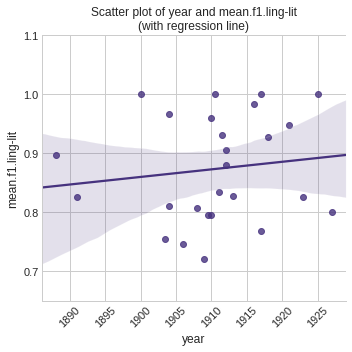

In [68]:
describe_data.describe_corpus_scatter(subgenres_results_df, wdir, "year","mean.f1.ling-lit","CoNSSA",fit_reg=True)

0.78 0.005580000000000001


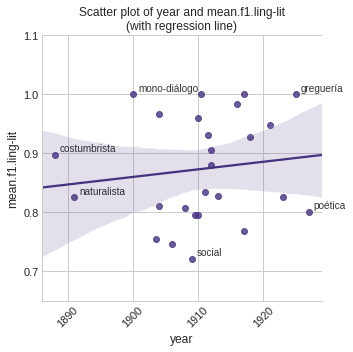

In [69]:
describe_data.describe_corpus_scatter(subgenres_results_df, wdir, "year","mean.f1.ling-lit","CoNSSA",fit_reg=True, annotation_lt = ["greguería","poética", "costumbrista", "naturalista", "mono-diálogo", "social"])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


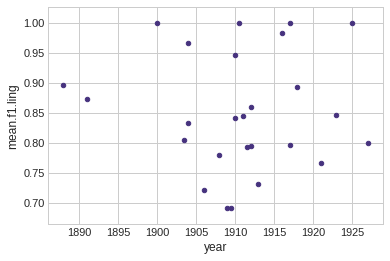

In [70]:
subgenres_results_df.plot.scatter("year","mean.f1.ling",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


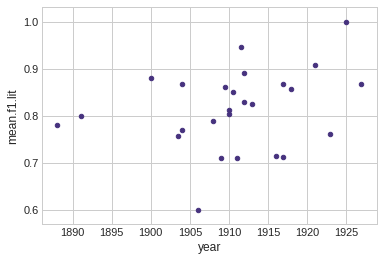

In [71]:
subgenres_results_df.plot.scatter("year","mean.f1.lit",)

Other similar hypothesis: are the younger writers easier to classify? 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


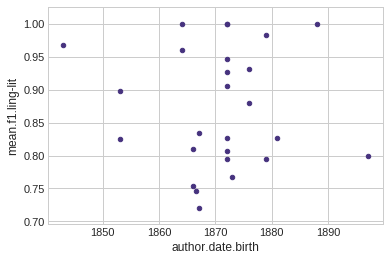

In [72]:
subgenres_results_df.plot.scatter("author.date.birth","mean.f1.ling-lit",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


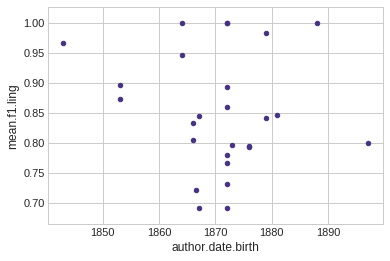

In [73]:
subgenres_results_df.plot.scatter("author.date.birth","mean.f1.ling",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


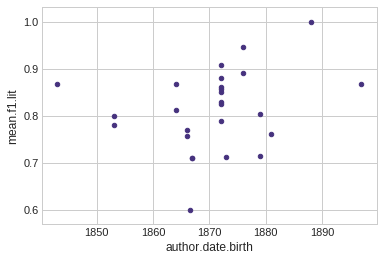

In [74]:
subgenres_results_df.plot.scatter("author.date.birth","mean.f1.lit",)

In [75]:
stats.linregress(
            subgenres_results_df["year"],
            subgenres_results_df["mean.f1.ling-lit"],
)

LinregressResult(slope=0.001284910551765982, intercept=-1.5818654415414883, rvalue=0.12967269376087293, pvalue=0.5278055388671776, stderr=0.002005563246993475)

In [76]:
stats.pearsonr(
    subgenres_results_df["year"],
    subgenres_results_df["mean.f1.ling-lit"],
)

(0.12967269376087295, 0.5278055388671781)

# 7.2.3. Number of Texts

What is the effect of the number of texts on the correlation? Does the classification improve with more texts (because it has more data) or does it get spoiled (because it has more variance)?

In [77]:
subgenres_results_df.sort_values(by="number.texts")[["number.texts","mean.f1.ling-lit"]]

,number.texts,mean.f1.ling-lit
greguería,2.0,1.000
nivola,5.0,1.000
poética,5.0,0.800
episodio nacional,11.0,0.967
mono-diálogo,11.0,1.000
diálogo,14.0,1.000
costumbrista,16.0,0.897
erótica,17.0,0.960
psicológica,20.0,0.807
guerra,21.0,0.927


4.38 0.005580000000000001


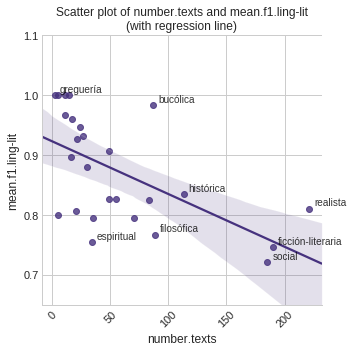

In [78]:
describe_data.describe_corpus_scatter(subgenres_results_df, wdir, "number.texts","mean.f1.ling-lit","CoNSSA",fit_reg=True, annotation_lt=["bucólica","social","ficción-literaria","realista","greguería","espiritual","histórica","filosófica"])

In [79]:
stats.linregress(
            subgenres_results_df["number.texts"],
            subgenres_results_df["mean.f1.ling-lit"],
)

LinregressResult(slope=-0.0008799242732624972, intercept=0.9225988216629425, rvalue=-0.5862693565020477, pvalue=0.0016467356460964273, stderr=0.00024819315178088177)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


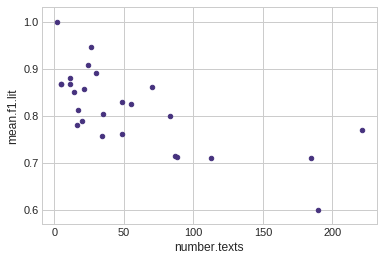

In [80]:
subgenres_results_df.plot.scatter("number.texts","mean.f1.lit",)

In [81]:
stats.linregress(
            subgenres_results_df["number.texts"],
            subgenres_results_df["mean.f1.lit"],

)


LinregressResult(slope=-0.0009896019157784705, intercept=0.8698003230366287, rvalue=-0.6996545507239124, pvalue=6.952898786094016e-05, stderr=0.00020628236505981868)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


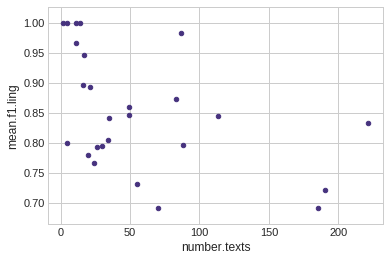

In [82]:
subgenres_results_df.plot.scatter("number.texts","mean.f1.ling",)

In [83]:
stats.linregress(
            subgenres_results_df["number.texts"],
            subgenres_results_df["mean.f1.ling"],
)

LinregressResult(slope=-0.0007580329946187284, intercept=0.8947879309668447, rvalue=-0.46496349117964886, pvalue=0.016695285623874834, stderr=0.00029462442276285386)

# 7.2.3. Number of Authors

Does the number of authors affect the results of the classification? Are the subgenres with fewer authors lighter to classify?

In [84]:
subgenres_results_df.sort_values(by="number.authors")[["number.authors","mean.f1.ling-lit"]]

,number.authors,mean.f1.ling-lit
greguería,1.0,1.000
nivola,1.0,1.000
episodio nacional,2.0,0.967
costumbrista,4.0,0.897
poética,5.0,0.800
mono-diálogo,7.0,1.000
diálogo,8.0,1.000
erótica,9.0,0.960
psicológica,11.0,0.807
autobiografía,12.0,0.931


0.98 0.005580000000000001


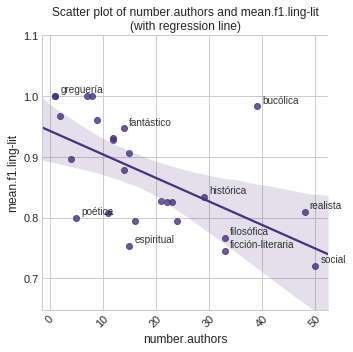

In [85]:
describe_data.describe_corpus_scatter(subgenres_results_df, wdir, "number.authors","mean.f1.ling-lit","CoNSSA",fit_reg=True, annotation_lt=["histórica","filosófica","ficción-literaria","bucólica","realista","social","greguería","poética","espiritual","fantástico"])

In [86]:
stats.linregress(
            subgenres_results_df["number.authors"],
            subgenres_results_df["mean.f1.ling-lit"],
)

LinregressResult(slope=-0.003869731800766283, intercept=0.9428090185676392, rvalue=-0.5852536715287225, pvalue=0.001685342066232586, stderr=0.0010943890968780363)

In [87]:
import statsmodels.api as sm
sm.OLS(
    subgenres_results_df["mean.f1.ling-lit"],
    subgenres_results_df[["number.authors"]],
).fit().summary()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.580
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              34.54
Date:                Mon, 16 Dec 2019   Prob (F-statistic):                    3.94e-06
Time:                        09:53:56   Log-Likelihood:                         -22.219
No. Observations:                  26   AIC:                                      46.44
Df Residuals:                      25   BIC:                                      47.70
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
number.authors     0.0298      0.005      5.877      0.000       0.019       0.040
==============================================================================
Omnibus:                        2.739   Durbin-Watson:                   0.939
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.138
Skew:                          -0.695   Prob(JB):                        0.343
Kurtosis:                       2.796   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


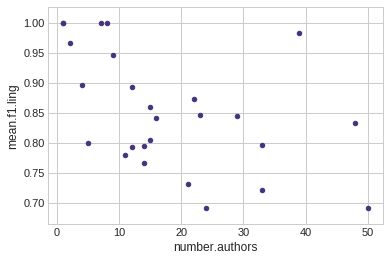

In [88]:
subgenres_results_df.plot.scatter("number.authors","mean.f1.ling",)

In [89]:
stats.linregress(
            subgenres_results_df["number.authors"],
            subgenres_results_df["mean.f1.ling"],
)

LinregressResult(slope=-0.003527671349510431, intercept=0.9156903919834954, rvalue=-0.4911682051617769, pvalue=0.01083324997066825, stderr=0.001277034673371574)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


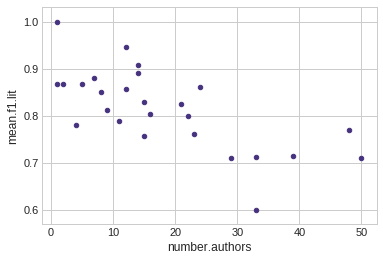

In [90]:
subgenres_results_df.plot.scatter("number.authors","mean.f1.lit",)

In [91]:
stats.linregress(
            subgenres_results_df["number.authors"],
            subgenres_results_df["mean.f1.lit"],
)

LinregressResult(slope=-0.00431502767134951, intercept=0.8918628057765988, rvalue=-0.6924973323497677, pvalue=8.846485527748325e-05, stderr=0.0009175892137152018)

# 7.2.4. Length of Novels

Are the longer texts lighter to classify?

In [92]:
subgenres_results_df.sort_values(by="am.tokens")[["mean.f1.ling-lit","am.tokens"]]

,mean.f1.ling-lit,am.tokens
poética,0.800,11813.0
greguería,1.000,20118.5
bucólica,0.983,22892.0
modernista,0.794,33441.0
diálogo,1.000,33880.0
mono-diálogo,1.000,34072.0
psicológica,0.807,38471.5
guerra,0.927,45472.0
nivola,1.000,49046.0
biografía,0.879,49597.5


1268.25 0.005580000000000001


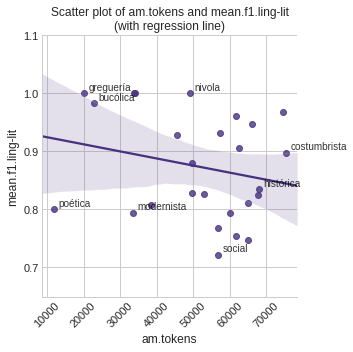

In [93]:
describe_data.describe_corpus_scatter(subgenres_results_df, wdir, "am.tokens","mean.f1.ling-lit","CoNSSA",fit_reg=True, annotation_lt=['poética', 'greguería', 'bucólica','histórica', 'costumbrista','nivola','social','modernista'])

In [94]:
stats.linregress(
            subgenres_results_df["am.tokens"],
            subgenres_results_df["mean.f1.ling-lit"],
)

LinregressResult(slope=-1.2247039521311157e-06, intercept=0.9362309042964108, rvalue=-0.2297124984272328, pvalue=0.25894843649747573, stderr=1.0591783431690867e-06)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


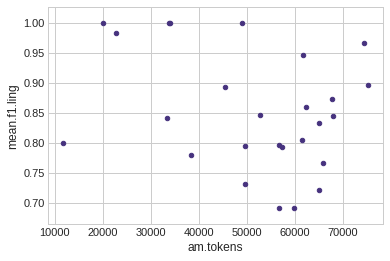

In [95]:
subgenres_results_df.plot.scatter("am.tokens","mean.f1.ling",)

In [96]:
stats.linregress(
            subgenres_results_df["am.tokens"],
            subgenres_results_df["mean.f1.lit"],
)

LinregressResult(slope=-1.5233802950329967e-06, intercept=0.8926523692245875, rvalue=-0.3032027101935996, pvalue=0.1321433246351141, stderr=9.773021350137543e-07)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


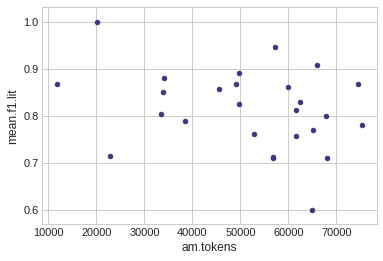

In [97]:
subgenres_results_df.plot.scatter("am.tokens","mean.f1.lit",)

In [98]:
stats.linregress(
            subgenres_results_df["am.tokens"],
            subgenres_results_df["mean.f1.ling"],
)

LinregressResult(slope=-1.6974254808345622e-06, intercept=0.9396163790860201, rvalue=-0.2931048945697017, pvalue=0.1461728189194842, stderr=1.130202830752614e-06)

# 7.2.6. Disagreement on Human Sources

Do the classification results and the agreement of the sources correlate? Are the hard subgenres hard for both humans and machines?

In [99]:
subgenres_results_df.sort_values(by="mean kappa")[["mean kappa", "mean.f1.ling-lit"]]

,mean kappa,mean.f1.ling-lit
filosófica,0.002363,0.767
realista,0.022280,0.810
biografía,0.031458,0.879
psicológica,0.035208,0.807
autobiografía,0.038491,0.931
fantástico,0.060426,0.947
espiritual,0.062858,0.754
educación,0.064364,0.794
modernista,0.075869,0.794
humor,0.097191,0.826


0.01879147417548692 0.005580000000000001


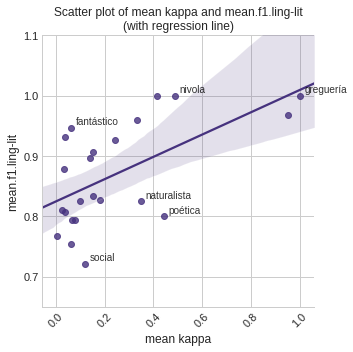

In [100]:
describe_data.describe_corpus_scatter(subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))], wdir, "mean kappa", "mean.f1.ling-lit","CoNSSA",fit_reg=True, annotation_lt=['greguería',"social","poética","naturalista","nivola","fantástico"])

In [82]:
stats.linregress(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean kappa"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.f1.ling-lit"]
)

LinregressResult(slope=0.18439866041346684, intercept=0.8247036400841256, rvalue=0.5913496269209016, pvalue=0.00296039249373998, stderr=0.054873484674747196)

In [83]:
stats.linregress(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean kappa"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.f1.ling"]
)

LinregressResult(slope=0.23541299298323898, intercept=0.7899651688577085, rvalue=0.7023836100270003, pvalue=0.00018657851651025938, stderr=0.05205992637760205)

In [84]:
stats.linregress(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean kappa"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.f1.lit"]
)

LinregressResult(slope=0.13432656595662368, intercept=0.7931319200741814, rvalue=0.4984241287669335, pvalue=0.015491870545655434, stderr=0.050984586736273665)

In [101]:
stats.pearsonr(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean kappa"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.f1.ling-lit"]
)

(0.5913496269209013, 0.0029603924937400055)

0.01879147417548692 0.0061800000000000015


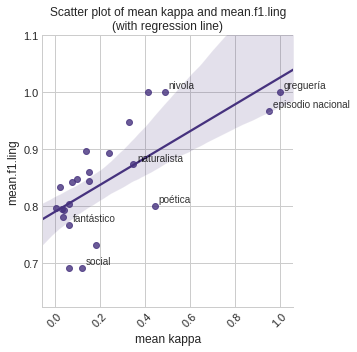

In [102]:
describe_data.describe_corpus_scatter(subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))], wdir, "mean kappa", "mean.f1.ling","CoNSSA",fit_reg=True, annotation_lt=['episodio nacional', 'greguería',"social","poética","naturalista","nivola","fantástico"])

In [103]:
stats.pearsonr(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean kappa"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.f1.ling"],
)

(0.7023836100270002, 0.00018657851651026)

In [104]:
stats.pearsonr(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean kappa"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.f1.lit"],
)

(0.4984241287669334, 0.015491870545655446)

In [105]:
subgenres_results_df.sort_values(by="mean.prop.subgenres")

,CoNSSA,CoNSSA.canon,HdLE,MdLE,am.adjectives,am.adpositions,am.adverbs,am.blocks,am.chapters,am.chars,...,setting.settlement.represented.exist,social,sum.subgenres,year,mean.f1.ling,mean.f1.lit,mean.f1.ling-lit,number pairs kappa,mean kappa,median kappa
greguería,1.0,0.0,0.0,1.0,1024.5,2942.5,702.5,1324.0,6.5,115010.5,...,1.0,0.0,5.0,1925.0,1.000,1.000,1.000,1.0,1.000000,1.000000
nivola,1.0,1.0,1.0,1.0,1191.0,3701.0,2327.0,1442.0,25.0,268111.0,...,1.0,1.0,7.0,1917.0,1.000,0.867,1.000,3.0,0.487496,0.497896
poética,1.0,0.0,1.0,1.0,812.0,1293.0,411.0,314.0,6.0,68358.0,...,1.0,0.0,6.0,1927.0,0.800,0.867,0.800,3.0,0.443297,0.438167
mono-diálogo,1.0,1.0,1.0,1.0,1637.0,4113.0,1814.0,746.0,25.0,212435.0,...,1.0,1.0,6.0,1900.0,1.000,0.880,1.000,NaN,NaN,NaN
episodio nacional,1.0,0.0,0.0,1.0,4724.0,11340.0,3941.0,716.0,32.0,427511.0,...,1.0,0.0,5.0,1904.0,0.967,0.867,0.967,1.0,0.950945,0.950945
costumbrista,1.0,0.0,1.0,1.0,3749.5,10334.0,4451.0,1835.0,25.5,427351.0,...,1.0,0.0,4.0,1888.0,0.897,0.780,0.897,2.0,0.140100,-0.004951
psicológica,1.0,0.5,1.0,1.0,2670.0,5468.0,2137.0,842.5,26.0,227356.0,...,1.0,0.5,6.0,1908.0,0.780,0.790,0.807,2.0,0.035208,-0.004442
diálogo,1.0,0.5,0.5,1.0,1673.0,4012.5,1815.5,2256.5,31.5,208837.5,...,1.0,1.0,6.0,1910.5,1.000,0.850,1.000,6.0,0.413620,0.357765
fantástico,1.0,0.0,1.0,1.0,3928.0,8092.0,2723.5,1323.5,26.5,389183.5,...,1.0,0.0,4.0,1921.0,0.767,0.907,0.947,4.0,0.060426,-0.004489
erótica,1.0,0.0,1.0,1.0,3509.0,8691.0,3292.0,1629.0,18.0,370595.0,...,1.0,1.0,3.0,1910.0,0.947,0.813,0.960,2.0,0.331232,0.199225


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


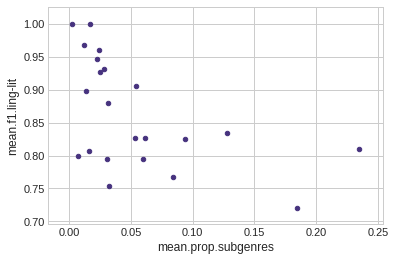

In [106]:
subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria","nivola"]))].plot.scatter("mean.prop.subgenres","mean.f1.ling-lit")

In [107]:
stats.pearsonr(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.prop.subgenres"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.f1.ling-lit"],
)

(-0.5471214958817567, 0.006895475751362097)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


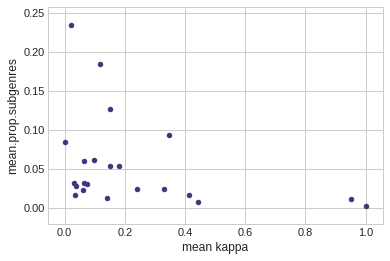

In [108]:
subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria","nivola"]))].plot.scatter("mean kappa","mean.prop.subgenres",)

In [109]:
stats.pearsonr(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean kappa"],
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["mean.prop.subgenres"]
)

(-0.3731240953607942, 0.079496263901894)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


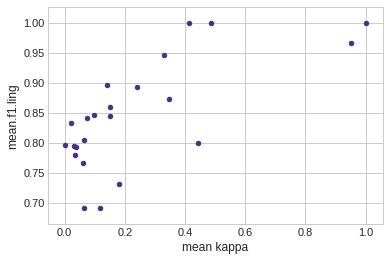

In [110]:
subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))].plot.scatter("mean kappa","mean.f1.ling",)

# 7.2.5. Canonicity of the Texts

Are the texts that are more important for the canon harde to classify?

In [65]:
new_metadata_df.loc[new_metadata_df["author.name"] == "Unamuno"][["title","litHist.pages"]]


,title,litHist.pages
ne0069,Abel,3.0
ne0070,Pedagogia,2.0
ne0072,TiaTula,1.0
ne0073,Niebla,10.0
ne0074,Manuel,8.0
ne0114,PazGuerra,2.0


In [66]:
subgenres_results_df.sort_values(by="litHist.pages")[["litHist.pages","mean.f1.ling-lit"]]

,litHist.pages,mean.f1.ling-lit
erótica,0.2,0.960
greguería,0.2,1.000
episodio nacional,0.2,0.967
guerra,0.5,0.927
memorias,0.5,0.827
fantástico,0.5,0.947
histórica,0.5,0.834
humor,0.5,0.826
bucólica,0.5,0.983
aventura,0.5,0.906


In [67]:
subgenres_results_df["litHist.pages"] = subgenres_results_df["litHist.pages"].astype(float)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


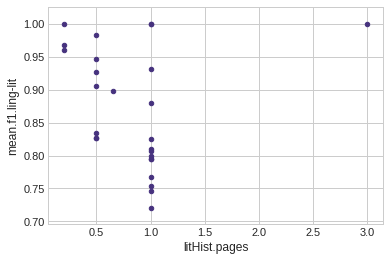

In [68]:
subgenres_results_df.plot.scatter("litHist.pages","mean.f1.ling-lit",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


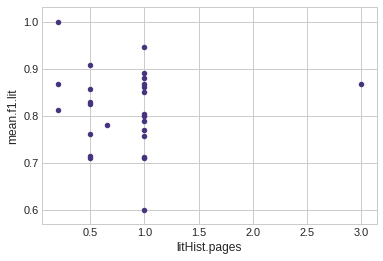

In [69]:
subgenres_results_df.plot.scatter("litHist.pages","mean.f1.lit",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


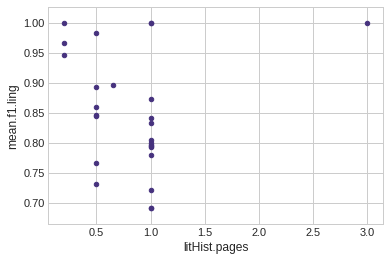

In [70]:
subgenres_results_df.plot.scatter("litHist.pages","mean.f1.ling",)

In [71]:
subgenres_results_df.sort_values(by="litHist.pages")[["litHist.pages","mean.f1.ling-lit"]]

,litHist.pages,mean.f1.ling-lit
erótica,0.20,0.960
greguería,0.20,1.000
episodio nacional,0.20,0.967
guerra,0.50,0.927
memorias,0.50,0.827
fantástico,0.50,0.947
histórica,0.50,0.834
humor,0.50,0.826
bucólica,0.50,0.983
aventura,0.50,0.906


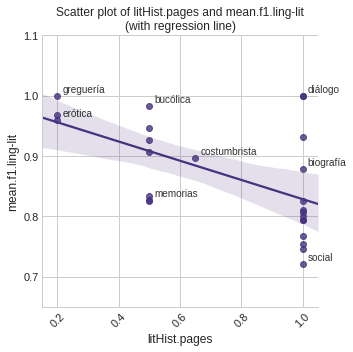

In [72]:
describe_data.describe_corpus_scatter(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["nivola"]))],
    wdir, "litHist.pages","mean.f1.ling-lit","CoNSSA",fit_reg=True,
annotation_lt=['erótica', 'greguería', 'bucólica',"diálogo","memorias","social","biografía","costumbrista"])


In [73]:
stats.linregress(
    subgenres_results_df.loc[(subgenres_results_df.index != "nivola")]["mean.f1.ling-lit"],
    subgenres_results_df.loc[(subgenres_results_df.index != "nivola")]["litHist.pages"],
)

LinregressResult(slope=-1.881958555673535, intercept=2.3836905830090824, rvalue=-0.5473906243275856, pvalue=0.004624436448150903, stderr=0.5999437538951686)

In [74]:
stats.linregress(
    subgenres_results_df.loc[(subgenres_results_df.index != "nivola")]["mean.f1.ling"],
    subgenres_results_df.loc[(subgenres_results_df.index != "nivola")]["litHist.pages"],
)

LinregressResult(slope=-1.4497700220343186, intercept=1.976911374247203, rvalue=-0.4549709373341463, pvalue=0.022303471289401414, stderr=0.5916822367960811)

In [75]:
stats.linregress(
    subgenres_results_df.loc[(subgenres_results_df.index != "nivola")]["mean.f1.lit"],
    subgenres_results_df.loc[(subgenres_results_df.index != "nivola")]["litHist.pages"],
)

LinregressResult(slope=-0.7994079812892853, intercept=1.3991832334454029, rvalue=-0.22680768143188584, pvalue=0.2755959103453629, stderr=0.7157787676358176)

In [76]:
subgenres_results_df["author.litHist.pages"] = subgenres_results_df["author.litHist.pages"].astype(float)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


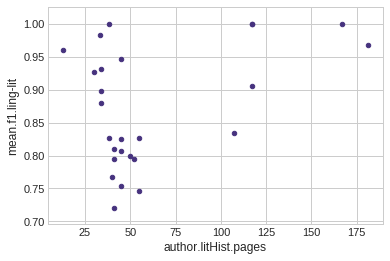

In [77]:
subgenres_results_df.plot.scatter("author.litHist.pages","mean.f1.ling-lit",)

In [81]:
stats.linregress(
    subgenres_results_df["mean.f1.ling-lit"],
    subgenres_results_df["author.litHist.pages"],
)


LinregressResult(slope=190.22783296892945, intercept=-103.98277938694753, rvalue=0.3961488883711991, pvalue=0.045129228073531334, stderr=89.99964587377372)

# 7.2.7. Specificity of the Features

Do the subgenres that have many and very distintive features lighter to classify?

In [85]:
subgenres_results_df

,CoNSSA,CoNSSA.canon,HdLE,MdLE,am.adjectives,am.adpositions,am.adverbs,am.blocks,am.chapters,am.chars,...,setting.settlement.represented.exist,social,sum.subgenres,year,mean.f1.ling,mean.f1.lit,mean.f1.ling-lit,number pairs kappa,mean kappa,median kappa
autobiografía,True,False,True,True,3662,7178,2570.5,1430.5,32,339926,...,True,0,7,1911.5,0.793,0.946,0.931,2.0,0.038491,-0.004421
aventura,True,False,True,True,3114,9123,2653,1801,31,355208,...,True,0,5,1912,0.860,0.829,0.906,8.0,0.151058,0.058975
biografía,True,False,True,True,3505,6935,2274.5,1274.5,29,287954,...,True,0,6.5,1912,0.795,0.891,0.879,2.0,0.031458,-0.008209
bucólica,True,False,True,True,1311,3069,988,729,14,135910,...,True,0,5,1916,0.983,0.714,0.983,NaN,NaN,NaN
costumbrista,True,False,True,True,3749.5,10334,4451,1835,25.5,427351,...,True,0,4,1888,0.897,0.780,0.897,2.0,0.140100,-0.004951
diálogo,1,0.5,0.5,1,1673,4012.5,1815.5,2256.5,31.5,208838,...,1,1,6,1910.5,1.000,0.850,1.000,6.0,0.413620,0.357765
educación,True,True,True,True,3465.5,8449,2823,1636.5,30,349076,...,True,1,6,1909.5,0.691,0.861,0.794,2.0,0.064364,0.082605
episodio nacional,True,False,False,True,4724,11340,3941,716,32,427511,...,True,0,5,1904,0.967,0.867,0.967,1.0,0.950945,0.950945
erótica,True,False,True,True,3509,8691,3292,1629,18,370595,...,True,1,3,1910,0.947,0.813,0.960,2.0,0.331232,0.199225
espiritual,True,True,True,True,3507,8966.5,2955.5,1326,25.5,353871,...,True,1,5,1903.5,0.804,0.758,0.754,2.0,0.062858,-0.004677


In [86]:
metadata_anno_features_df.loc[new_metadata_df.loc[new_metadata_df["guerra"]>0].index.tolist()].mean()

setting.settlement.represented.exist    0.952381
representation_ordinal                  1.000000
setting.continent_Europe                0.857143
setting.country_Spain                   0.666667
protagonist.gender_male                 0.857143
setting.type_ordinal                    0.634921
narrator_heterodiegetic                 0.714286
time.period_ordinal                     0.750000
protagonist.age_ordinal                 0.619048
protagonist.socLevel_ordinal            0.523810
time.span                               0.043213
setting.represented_unknown             0.000000
protagonist.profession_worker           0.000000
setting.territory_unknown               0.000000
protagonist.profession_religious        0.000000
setting.country_France                  0.095238
setting.represented_mixed               0.047619
setting.territory_Galicia               0.047619
protagonist.profession_seaman           0.047619
setting.continent_mixed                 0.047619
setting.settlement_?

Obtaining a data-frame with the z-scores of the features considering only the texts that belong to a genre:

In [87]:
subgenres_features_results_df = pd.DataFrame([],)

for subgenre in semantic_subgenres_lt:
    subgenres_features_results_df[subgenre] = metadata_anno_features_df.loc[new_metadata_df.loc[new_metadata_df[subgenre]>0].index.tolist()].mean()

subgenres_features_results_df = subgenres_features_results_df.T
zscores_subgenres_features_results_df = text2features.calculate_zscore(subgenres_features_results_df)

In [88]:
zscores_subgenres_features_results_df.iloc[:,0:500].T.sort_values(by="guerra", ascending=False)["guerra"].head(10).round(2)

protagonist.profession_military personnel    4.16
setting.territory_Navarra                    3.83
setting.represented_Bilbao                   3.24
setting.settlement_Bilbao                    3.24
setting.represented_Europe                   2.64
setting.territory_Cantabria                  2.59
hombres@form_noun@pos                        2.53
setting.continent_Africa                     2.47
setting.represented_Oviedo                   2.45
setting.country_France                       2.45
Name: guerra, dtype: float64

In [89]:
zscores_subgenres_features_results_df.sort_values(by="am.verses")

,setting.settlement.represented.exist,representation_ordinal,setting.continent_Europe,setting.country_Spain,protagonist.gender_male,setting.type_ordinal,narrator_heterodiegetic,time.period_ordinal,protagonist.age_ordinal,protagonist.socLevel_ordinal,...,formalizó@form_verb@pos,volvime@form_adjective@pos,pegadito@form_verb@pos,lavarán@form_verb@pos,abrumo@form_verb@pos,cestillos@form_noun@pos,glicina@form_noun@pos,patriarcalmente@form_adverb@pos,impeler@form_verb@pos,fumadora@form_noun@pos
greguería,0.963545,-2.034567,1.285944,1.600290,-3.853883,2.818799,1.792536,0.720500,1.461281,-0.677528,...,-0.618756,-0.530799,-0.483684,-0.658826,-0.314123,-0.775662,-0.490092,-0.676121,-0.474384,-0.321055
episodio nacional,0.963545,-0.723744,0.098009,0.828267,0.248777,1.576949,-0.232822,0.720500,0.704598,-0.677528,...,-0.618756,-0.530799,-0.483684,-0.658826,-0.314123,-0.775662,-0.490092,-0.676121,-0.474384,-0.321055
naturalista,0.301856,0.849243,1.128507,1.293341,-0.772769,-0.102543,0.772536,0.482521,-0.093111,-1.600222,...,1.411640,0.148976,0.022774,0.068934,-0.314123,-0.762328,-0.490092,0.778961,0.431702,0.116032
fantástico,-3.041055,-3.716789,-2.525349,-1.584306,0.533684,0.399777,-0.621015,-2.160040,0.594248,0.120218,...,-0.618756,-0.530799,-0.483684,-0.658826,-0.314123,-0.775662,-0.490092,2.875938,2.121418,-0.321055
costumbrista,0.105417,0.669005,0.469239,1.069524,-1.660099,-1.236620,1.792536,0.720500,-1.920147,1.715710,...,3.724811,-0.530799,3.508858,-0.658826,-0.314123,-0.775662,-0.490092,-0.676121,-0.474384,-0.321055
humor,-0.717686,-0.445529,-0.580811,-0.652757,0.034806,1.564277,0.883192,0.922054,0.272207,0.885403,...,-0.618756,-0.530799,0.663143,-0.658826,-0.314123,0.896318,0.963704,-0.676121,-0.474384,1.381215
mono-diálogo,-1.532829,0.062750,0.098009,0.056243,-0.207074,0.024635,-2.258180,0.720500,0.704598,0.192740,...,-0.618756,-0.530799,-0.483684,-0.658826,-0.314123,-0.775662,-0.490092,-0.676121,-0.474384,-0.321055
espiritual,0.963545,0.594789,0.517280,0.850973,-0.314333,-0.194515,0.482010,-2.184246,-0.619598,-0.959085,...,-0.618756,-0.530799,-0.450128,1.488534,-0.314123,1.259286,-0.490092,-0.676121,-0.474384,-0.321055
social,0.295596,0.615421,0.791506,0.728112,-0.140545,-0.227092,0.540098,0.400193,-0.068446,-0.936256,...,0.065151,0.073352,0.231330,0.035617,0.340137,0.048314,-0.010126,0.516144,1.045758,-0.124956
modernista,-0.213317,0.190087,-0.954163,-0.098161,0.587409,-1.376882,0.264837,-1.536903,-0.084515,0.416524,...,0.541348,-0.530799,-0.483684,2.678155,-0.314123,1.169525,-0.490092,-0.676121,-0.474384,-0.321055


In [90]:
zscores_subgenres_features_results_df.std(axis=1).sort_values().round(2)

ficción-literaria    0.34
realista             0.39
social               0.40
filosófica           0.49
educación            0.50
histórica            0.53
memorias             0.58
bucólica             0.65
biografía            0.65
naturalista          0.66
autobiografía        0.71
espiritual           0.72
humor                0.72
fantástico           0.79
psicológica          0.82
aventura             0.82
modernista           0.87
guerra               0.97
diálogo              0.98
erótica              1.00
costumbrista         1.03
mono-diálogo         1.06
episodio nacional    1.30
poética              1.34
nivola               1.47
greguería            2.08
dtype: float64

Appending this information to the comparison data-frame:

In [91]:
subgenres_results_df["std.zscores.features"] = zscores_subgenres_features_results_df.std(axis=1).sort_index()

In [92]:
subgenres_results_df.sort_values(by="std.zscores.features")[["std.zscores.features","mean.f1.ling-lit"]]

,std.zscores.features,mean.f1.ling-lit
ficción-literaria,0.343296,0.746
realista,0.394991,0.810
social,0.396142,0.721
filosófica,0.488111,0.767
educación,0.504521,0.794
histórica,0.534361,0.834
memorias,0.575924,0.827
bucólica,0.646991,0.983
biografía,0.649345,0.879
naturalista,0.657658,0.825


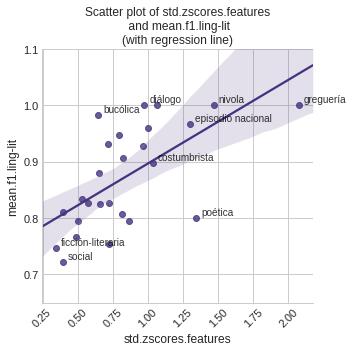

In [93]:
describe_data.describe_corpus_scatter(
    subgenres_results_df,
    wdir, "std.zscores.features","mean.f1.ling-lit","CoNSSA", fit_reg=True, annotation_lt=["greguería","nivola","poética","episodio nacional","diálogo","costumbrista","bucólica","ficción-literaria","social"])

In [94]:
stats.linregress(
    subgenres_results_df["mean.f1.ling-lit"],
    subgenres_results_df["std.zscores.features"],
            )

LinregressResult(slope=2.702418980551507, intercept=-1.5179548711597373, rvalue=0.6337504163889474, pvalue=0.0005090060035437293, stderr=0.6733025037273571)

In [136]:
stats.pearsonr(
    subgenres_results_df["mean.f1.ling-lit"],
    subgenres_results_df["std.zscores.features"],
            )

(0.6337504163889475, 0.0005090060035437274)

In [137]:
subgenres_results_df[["mean.f1.ling-lit","std.zscores.features"]]

,mean.f1.ling-lit,std.zscores.features
autobiografía,0.931,0.712796
aventura,0.906,0.821545
biografía,0.879,0.649345
bucólica,0.983,0.646991
costumbrista,0.897,1.034574
diálogo,1.000,0.975872
educación,0.794,0.504521
episodio nacional,0.967,1.299693
erótica,0.960,1.001893
espiritual,0.754,0.720156


# 7.2.8. Correlation and Regression of Variables

Observing the correlations between the variables:

In [138]:
correlation_df = subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria","nivola"]))][["mean.f1.ling-lit","number.texts","number.authors","mean kappa","litHist.pages", "std.zscores.features"]].corr()

In [139]:
correlation_df

,mean.f1.ling-lit,number.texts,number.authors,mean kappa,litHist.pages,std.zscores.features
mean.f1.ling-lit,1.000000,-0.562212,-0.665667,0.568129,-0.612605,0.616868
number.texts,-0.562212,1.000000,0.956912,-0.371004,0.323994,-0.649664
number.authors,-0.665667,0.956912,1.000000,-0.519502,0.388854,-0.761023
mean kappa,0.568129,-0.371004,-0.519502,1.000000,-0.566825,0.831656
litHist.pages,-0.612605,0.323994,0.388854,-0.566825,1.000000,-0.514965
std.zscores.features,0.616868,-0.649664,-0.761023,0.831656,-0.514965,1.000000


In [132]:
correlation_df = correlation_df.abs()

In [133]:
correlation_df.abs().mean().sort_values().round(2)

litHist.pages           0.57
mean kappa              0.64
number.texts            0.64
mean.f1.ling-lit        0.67
number.authors          0.72
std.zscores.features    0.73
dtype: float64

In [134]:
correlation_df = correlation_df.reindex(correlation_df.abs().mean().sort_values(ascending=True).index, axis=1)
correlation_df = correlation_df.reindex(correlation_df.abs().mean().sort_values(ascending=True).index, axis=0)


In [135]:
correlation_df

,litHist.pages,mean kappa,number.texts,mean.f1.ling-lit,number.authors,std.zscores.features
litHist.pages,1.000000,0.566825,0.323994,0.612605,0.388854,0.514965
mean kappa,0.566825,1.000000,0.371004,0.568129,0.519502,0.831656
number.texts,0.323994,0.371004,1.000000,0.562212,0.956912,0.649664
mean.f1.ling-lit,0.612605,0.568129,0.562212,1.000000,0.665667,0.616868
number.authors,0.388854,0.519502,0.956912,0.665667,1.000000,0.761023
std.zscores.features,0.514965,0.831656,0.649664,0.616868,0.761023,1.000000


Creating a heat-map for the visualization:

In [136]:
def heatmap(wdir, df, title, absolute = True, format_="png"):
    correlation_df = df.corr()
    if absolute == True:
        correlation_df = correlation_df.abs()
    
    correlation_df = correlation_df.reindex(correlation_df.mean().sort_values(ascending=True).index, axis=1)
    correlation_df = correlation_df.reindex(correlation_df.mean().sort_values(ascending=True).index, axis=0)

    fig, ax = plt.subplots()
    ax = plt.pcolor(correlation_df, cmap="Reds", vmin=0.2, vmax=1)
    plt.title(title)
    plt.yticks(np.arange(0.5, len(correlation_df.index), 1), correlation_df.index)
    plt.xticks(np.arange(0.5, len(correlation_df.columns), 1), correlation_df.columns, rotation=90)
    fig.tight_layout()
    describe_data.create_dir(wdir, "/visualisations")
    ax.get_figure().savefig(wdir + "/visualisations/" + title + "_heatmap_." + format_, dpi = 300, format = format_)
    fig.show()

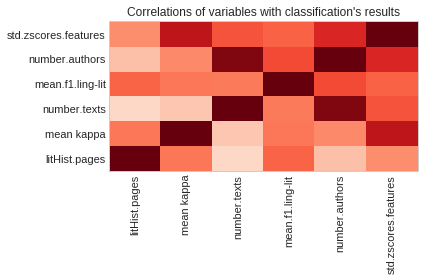

In [137]:
heatmap(wdir, subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria","nivola"]))][["mean.f1.ling-lit","number.texts","number.authors","mean kappa","litHist.pages", "std.zscores.features"]],
        "Correlations of variables with classification's results", absolute = True)


Exploring all the variable pairwise:

In [138]:
stats.spearmanr(
            subgenres_results_df["number.texts"],
            subgenres_results_df["number.authors"],
            )

SpearmanrResult(correlation=0.9763780099728805, pvalue=1.7665147749556632e-17)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


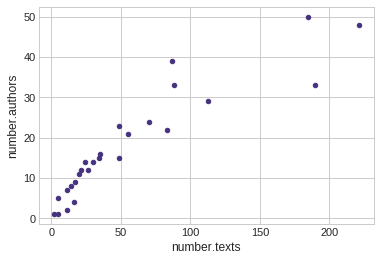

In [139]:
subgenres_results_df.plot.scatter("number.texts","number.authors",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


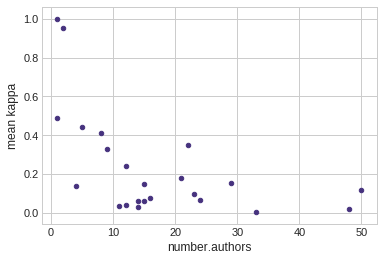

In [140]:
subgenres_results_df.plot.scatter("number.authors","mean kappa",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


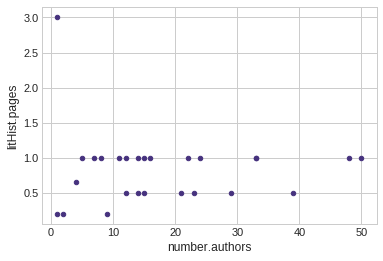

In [141]:
subgenres_results_df.plot.scatter("number.authors","litHist.pages",)

In [142]:
subgenres_results_df

,CoNSSA,CoNSSA.canon,HdLE,MdLE,am.adjectives,am.adpositions,am.adverbs,am.blocks,am.chapters,am.chars,...,social,sum.subgenres,year,mean.f1.ling,mean.f1.lit,mean.f1.ling-lit,number pairs kappa,mean kappa,median kappa,std.zscores.features
autobiografía,1.0,0.0,1.0,1.0,3662.0,7178.0,2570.5,1430.5,32.0,339926.0,...,0.0,7.0,1911.5,0.793,0.946,0.931,2.0,0.038491,-0.004421,0.712796
aventura,1.0,0.0,1.0,1.0,3114.0,9123.0,2653.0,1801.0,31.0,355208.0,...,0.0,5.0,1912.0,0.860,0.829,0.906,8.0,0.151058,0.058975,0.821545
biografía,1.0,0.0,1.0,1.0,3505.0,6935.0,2274.5,1274.5,29.0,287953.5,...,0.0,6.5,1912.0,0.795,0.891,0.879,2.0,0.031458,-0.008209,0.649345
bucólica,1.0,0.0,1.0,1.0,1311.0,3069.0,988.0,729.0,14.0,135910.0,...,0.0,5.0,1916.0,0.983,0.714,0.983,NaN,NaN,NaN,0.646991
costumbrista,1.0,0.0,1.0,1.0,3749.5,10334.0,4451.0,1835.0,25.5,427351.0,...,0.0,4.0,1888.0,0.897,0.780,0.897,2.0,0.140100,-0.004951,1.034574
diálogo,1.0,0.5,0.5,1.0,1673.0,4012.5,1815.5,2256.5,31.5,208837.5,...,1.0,6.0,1910.5,1.000,0.850,1.000,6.0,0.413620,0.357765,0.975872
educación,1.0,1.0,1.0,1.0,3465.5,8449.0,2823.0,1636.5,30.0,349076.5,...,1.0,6.0,1909.5,0.691,0.861,0.794,2.0,0.064364,0.082605,0.504521
episodio nacional,1.0,0.0,0.0,1.0,4724.0,11340.0,3941.0,716.0,32.0,427511.0,...,0.0,5.0,1904.0,0.967,0.867,0.967,1.0,0.950945,0.950945,1.299693
erótica,1.0,0.0,1.0,1.0,3509.0,8691.0,3292.0,1629.0,18.0,370595.0,...,1.0,3.0,1910.0,0.947,0.813,0.960,2.0,0.331232,0.199225,1.001893
espiritual,1.0,1.0,1.0,1.0,3507.0,8966.5,2955.5,1326.0,25.5,353871.0,...,1.0,5.0,1903.5,0.804,0.758,0.754,2.0,0.062858,-0.004677,0.720156


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


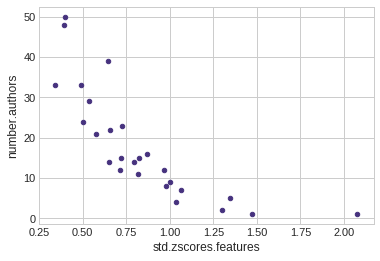

In [143]:
subgenres_results_df.plot.scatter("std.zscores.features","number.authors",)#

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


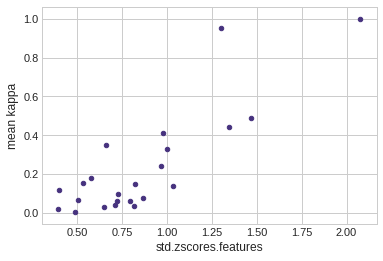

In [144]:
subgenres_results_df.plot.scatter("std.zscores.features","mean kappa",)#

In [145]:
stats.spearmanr(
        subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo", "ficción-literaria"]))]["mean kappa"], #
        subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria"]))]["std.zscores.features"], #
            )

SpearmanrResult(correlation=0.6936758893280633, pvalue=0.00024187477334009646)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


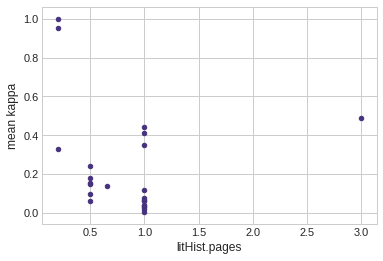

In [146]:
subgenres_results_df.plot.scatter("litHist.pages","mean kappa",)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


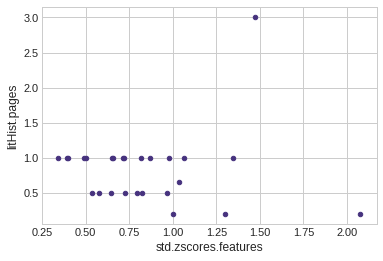

In [147]:
subgenres_results_df.plot.scatter("std.zscores.features","litHist.pages",)#

## Regression on Causes

Runnning regression on possibles causes of the variance of the classification:

In [148]:
sm.OLS(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria",]))]["mean.f1.ling-lit"], #
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria",]))][["number.texts","number.authors","mean kappa","litHist.pages", "std.zscores.features"]],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              130.3
Date:                Thu, 28 Nov 2019   Prob (F-statistic):                    1.74e-13
Time:                        10:00:07   Log-Likelihood:                          12.093
No. Observations:                  23   AIC:                                     -14.19
Df Residuals:                      18   BIC:                                     -8.508
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
number.texts            -0.0032      0.002     -1.433      0.169      -0.008       0.001
number.authors           0.0245      0.009      2.790      0.012       0.006       0.043
mean kappa              -0.2156      0.257     -0.839      0.413      -0.756       0.325
litHist.pages            0.0385      0.065      0.591      0.562      -0.098       0.175
std.zscores.features     0.7172      0.138      5.197      0.000       0.427       1.007
==============================================================================
Omnibus:                        2.221   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.329   Jarque-Bera (JB):                1.888
Skew:                          -0.607   Prob(JB):                        0.389
Kurtosis:                       2.295   Cond. No.                         667.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [149]:
sm.OLS(
    subgenres_results_df["mean.f1.ling-lit"], #
    subgenres_results_df[["litHist.pages","std.zscores.features"]],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                              113.5
Date:                Thu, 28 Nov 2019   Prob (F-statistic):                    5.81e-13
Time:                        10:00:07   Log-Likelihood:                         -2.9787
No. Observations:                  26   AIC:                                      9.957
Df Residuals:                      24   BIC:                                      12.47
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
litHist.pages            0.2576      0.089      2.880      0.008       0.073       0.442
std.zscores.features     0.6733      0.096      7.044      0.000       0.476       0.871
==============================================================================
Omnibus:                       19.798   Durbin-Watson:                   1.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.665
Skew:                          -1.801   Prob(JB):                     4.41e-06
Kurtosis:                       6.128   Cond. No.                         2.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
sm.OLS(
    subgenres_results_df["mean.f1.ling-lit"], #
    subgenres_results_df[["number.authors", "std.zscores.features"]],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              343.7
Date:                Thu, 28 Nov 2019   Prob (F-statistic):                    2.18e-18
Time:                        10:00:07   Log-Likelihood:                          10.558
No. Observations:                  26   AIC:                                     -17.12
Df Residuals:                      24   BIC:                                     -14.60
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
number.authors           0.0143      0.002      8.215      0.000       0.011       0.018
std.zscores.features     0.7008      0.042     16.573      0.000       0.614       0.788
==============================================================================
Omnibus:                       11.654   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.337
Skew:                          -1.263   Prob(JB):                      0.00569
Kurtosis:                       4.778   Cond. No.                         28.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
sm.OLS(
    subgenres_results_df["mean.f1.ling-lit"], #
    subgenres_results_df[["number.authors", "std.zscores.features"]],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              343.7
Date:                Thu, 28 Nov 2019   Prob (F-statistic):                    2.18e-18
Time:                        10:00:07   Log-Likelihood:                          10.558
No. Observations:                  26   AIC:                                     -17.12
Df Residuals:                      24   BIC:                                     -14.60
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
number.authors           0.0143      0.002      8.215      0.000       0.011       0.018
std.zscores.features     0.7008      0.042     16.573      0.000       0.614       0.788
==============================================================================
Omnibus:                       11.654   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.337
Skew:                          -1.263   Prob(JB):                      0.00569
Kurtosis:                       4.778   Cond. No.                         28.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
sm.OLS(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria",]))]["mean.f1.ling-lit"], #
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria",]))][["number.authors","litHist.pages"]],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              33.68
Date:                Thu, 28 Nov 2019   Prob (F-statistic):                    2.80e-07
Time:                        10:00:07   Log-Likelihood:                         -12.972
No. Observations:                  23   AIC:                                      29.94
Df Residuals:                      21   BIC:                                      32.21
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
number.authors     0.0146      0.006      2.526      0.020       0.003       0.027
litHist.pages      0.5194      0.123      4.219      0.000       0.263       0.775
==============================================================================
Omnibus:                        0.226   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.296
Skew:                          -0.201   Prob(JB):                        0.862
Kurtosis:                       2.617   Cond. No.                         28.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
sm.OLS(
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria","nivola"]))]["mean.f1.ling-lit"], #
    subgenres_results_df.loc[~(subgenres_results_df.index.isin(["bucólica","mono-diálogo","ficción-literaria","nivola"]))][["number.texts","number.authors","mean kappa","litHist.pages"]],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              71.47
Date:                Thu, 28 Nov 2019   Prob (F-statistic):                    8.50e-11
Time:                        10:00:07   Log-Likelihood:                          3.0332
No. Observations:                  22   AIC:                                      1.934
Df Residuals:                      18   BIC:                                      6.298
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
number.texts      -0.0073      0.003     -2.432      0.026      -0.014      -0.001
number.authors     0.0362      0.013      2.760      0.013       0.009       0.064
mean kappa         0.9507      0.159      5.983      0.000       0.617       1.285
litHist.pages      0.4787      0.143      3.344      0.004       0.178       0.779
==============================================================================
Omnibus:                        0.824   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.718
Skew:                           0.083   Prob(JB):                        0.698
Kurtosis:                       2.131   Cond. No.                         282.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
sm.OLS(
    subgenres_results_df["mean.f1.ling-lit"], #
    subgenres_results_df[["litHist.pages","std.zscores.features","number.authors"]],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       mean.f1.ling-lit   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                              233.4
Date:                Thu, 28 Nov 2019   Prob (F-statistic):                    2.34e-17
Time:                        10:00:07   Log-Likelihood:                          11.324
No. Observations:                  26   AIC:                                     -16.65
Df Residuals:                      23   BIC:                                     -12.87
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
litHist.pages            0.0703      0.059      1.182      0.249      -0.053       0.193
std.zscores.features     0.6563      0.056     11.640      0.000       0.540       0.773
number.authors           0.0132      0.002      6.791      0.000       0.009       0.017
==============================================================================
Omnibus:                        5.638   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                4.200
Skew:                          -0.973   Prob(JB):                        0.122
Kurtosis:                       3.306   Cond. No.                         51.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""